# <center>Предсказание цены алмазов</center>

<center> <img src=../img/diamonds.jpg> </center>

Датасет был взят с [*Kaggle*](https://www.kaggle.com/datasets/shivam2503/diamonds)

## <center>Навигация по ноутбуку</center>
1. [<font size=5>Знакомство с данными</font>](#start)
2. [<font size=5>Визуальный анализ данных</font>](#visual)

    2.1 [Распределение числовых факторов](#numeric)

    2.2 [Распределение категориальных факторов](#categories)

    2.3 [Сравнение зависимости цены алмаза от веса](#price_weight)
    
    2.4 [Сравнение средней цены алмаза в зависимости от его качества огранки](#price_cut)

    2.5 [Сравнение средней цены алмаза в зависимости от его цвета](#price_color)

    2.6 [Сравнение зависимости средней цены алмаза от его качества огранки и уровня чистоты](#price_cut_clarity)

    2.7 [Сравнение зависимости веса алмаза от качества огранки и уровня чистоты](#weight_cut_clarity)

    2.8 [Распределение количества алмазов в датасете в разрезе их цвета и чистоты](#count_color_clarity)

3. [<font size=5>Статистические тесты</font>](#stat_tests)

    3.1 [Сравнение двух групп чистоты *SI2* и *I1*](#stat_price_clarity)

    3.2 [Существует ли разница в цене алмаза в зависимости от качества огранки](#stat_price_cut)

    3.3 [Сравнение средней цены алмазов идеальной чистоты (*IF*) между группами с качеством огранки *Good* и *Premium*](#stat_price_clarity_cut)

    3.4 [Существует ли взаимосвязь между чистотой алмаза и его цветом](#stat_clarity_color)
    
4. [<font size=5>EDA</font>](#eda)

    4.1 [Кодирование категориальных признаков](#eda_encoding)

    4.2 [Матрица корреляции](#eda_corr_matrix)

5. [<font size=5>Machine Learning (без учёта веса)</font>](#ml_without_weight)

    5.1 [Выбор метрики, разделение данных на обучающую и тестовую выборки](#ml_start)

    5.2 [Создание пайплайна предобработки данных](#ml_preprocessing)

    5.3 [*LinearRegression* (линейная регрессия)](#ml_lr)

    5.4 [*DecisionTreeRegressor* (решающее дерево)](#ml_dt)

    5.5 [*LinearRegression & PolynomialFeatures* (линейная регрессия на полиномиальных признаках)](#ml_lr_pf)

    5.6 [*DecisionTreeRegressor* (с подбором гиперпараметров)](#ml_dt_optuna)

    5.7 [*RandomForestRegressor* (случайный лес)](#ml_rf)

    5.8 [*XGBRegressor* (градиентный бустинг)](#ml_xgb)

    5.9 [Промежуточный вывод](#ml_partial_conclusion)

6. [<font size=5>Machine Learning (с учётом веса)</font>](#ml_with_weight)

    6.1 [Разделение выборки на обучающую и тестовую](#ml_change_1)

    6.2 [Изменение пайплайна предобработки данных](#ml_change_2)

    6.3 [*LinearRegression* (линейная регрессия)](#ml_lr_2)

    6.4 [*LinearRegression & PolynomialFeatures* (линейная регрессия на полиномиальных признаках)](#ml_lr_pf_2)

    6.5 [*SGDRegressor* (стохастический градиентный спуск)](#ml_sgd)

    6.6 [*MLPRegressor* (нейронная сеть)](#ml_nn)

7. [<font size=5>Вывод по проделанной работе</font>](#conclusion)

<a id="start"></a>

## <center>Знакомство с данными</center>
**Описание признаков:**
* `carat` - вес алмаза
* `cut` - качество огранки (`Fair`, `Good`, `Very Good`, `Premium`, `Ideal`)
* `color` - цвет алмаза от `D` (прозрачный, наилучшее качество), до `J` (наихудшее качество)
* `clarity` - мера чистоты и редкости камня в следующем порядке от худшего показателя к лучшему:
    * `I1` > `SI2` > `SI1` > `VS2` > `VS1` > `VVS2` > `VVS1` > `IF`
* `depth` - общий процент глубины показывает, весит ли алмаз больше или меньше. В идеале общий процент глубины должен находиться в диапазоне от 57,5% ​​до 63%
* `table` - ширина вершины алмаза относительно самого широкого места
* `x`, `y`, `z` - длина, ширина и глубина алмаза в миллиметрах

**Целевой признак:**
* `price` - цена алмаза в долларах США


In [1]:
import time
# работа с данными
import pandas as pd
import numpy as np
# визуализация
import plotly.express as px
import plotly.io as pio
# подбор гиперпараметров
import optuna
from optuna import Trial
# сериализация/десериализация модели
import pickle
# ML
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
# статистические тесты
from scipy import stats
# отображение Markdown в output ячейках
from IPython.display import Markdown
# конфигурация библиотек
pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
optuna.logging.set_verbosity(optuna.logging.WARNING)
# для воспроизводимости результатов
RANDOM_STATE = 42

In [2]:
data = pd.read_csv('../data/diamonds.csv', index_col=0)
display(
    Markdown('### Пример данных'),
    data.sample(3, random_state=RANDOM_STATE)
)
display(Markdown('### Информация о значениях в столбцах'))
data.info()
n_duplicates = data.duplicated().sum()
n_nan = pd.DataFrame(data.isna().sum()).rename(columns={0: 'Количество пропусков'}).T
display(
    Markdown(f'### Пропуски в столбцах:'),
    n_nan,
    Markdown(f'### Количество дубликатов: {n_duplicates}')
)

### Пример данных

,carat,cut,color,clarity,depth,table,price,x,y,z
1389,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
50053,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
41646,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95


### Информация о значениях в столбцах

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


### Пропуски в столбцах:

,carat,cut,color,clarity,depth,table,price,x,y,z
Количество пропусков,0,0,0,0,0,0,0,0,0,0


### Количество дубликатов: 146

Избавимся от дубликатов в данных, а также проверим, есть ли неявные пропуски, заполненные, например, нулями.

In [3]:
data.drop_duplicates(inplace=True)
data.replace(0, np.nan, inplace=True)
n_nan = pd.DataFrame(data.isna().sum()).rename(columns={0: 'Количество нулей'}).T
display(
    Markdown(f'Количество дубликатов после очистки: {data.duplicated().sum()}'),
    Markdown(f'Неявные пропуски в столбцах:'),
    n_nan
)

Количество дубликатов после очистки: 0

Неявные пропуски в столбцах:

,carat,cut,color,clarity,depth,table,price,x,y,z
Количество нулей,0,0,0,0,0,0,0,7,6,19


Удалим строки, где есть нулевые `x`, `y` и `z`

In [4]:
data.dropna(axis=0, inplace=True)

Так как в данных есть вес алмаза, то он наверняка коррелирует с его ценой, поэтому создадим отдельный признак, обозначающий цену в долларах США за 1 карат. Таким образом, мы избавимся от зависимости цены от веса. Это поможет визуализировать цену в разрезе категорий

In [5]:
data_copy = data.copy()
data_copy['price_per_carat'] = data_copy['price'] / data_copy['carat']

***
<a id="visual"></a>

## <center>Визуальный анализ данных</center>

<a id="numeric"></a>

### Распределение факторов, состоящих из чисел

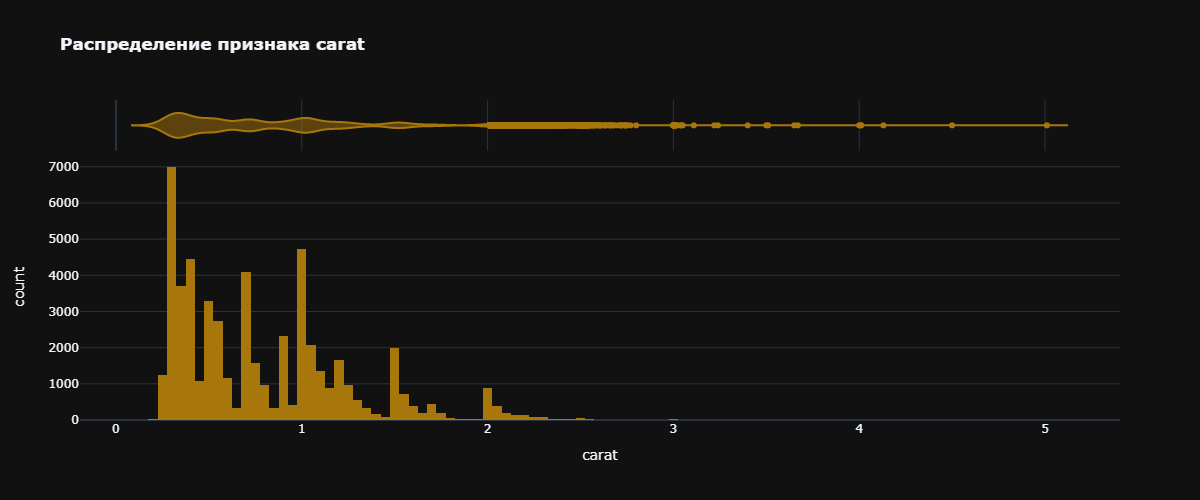

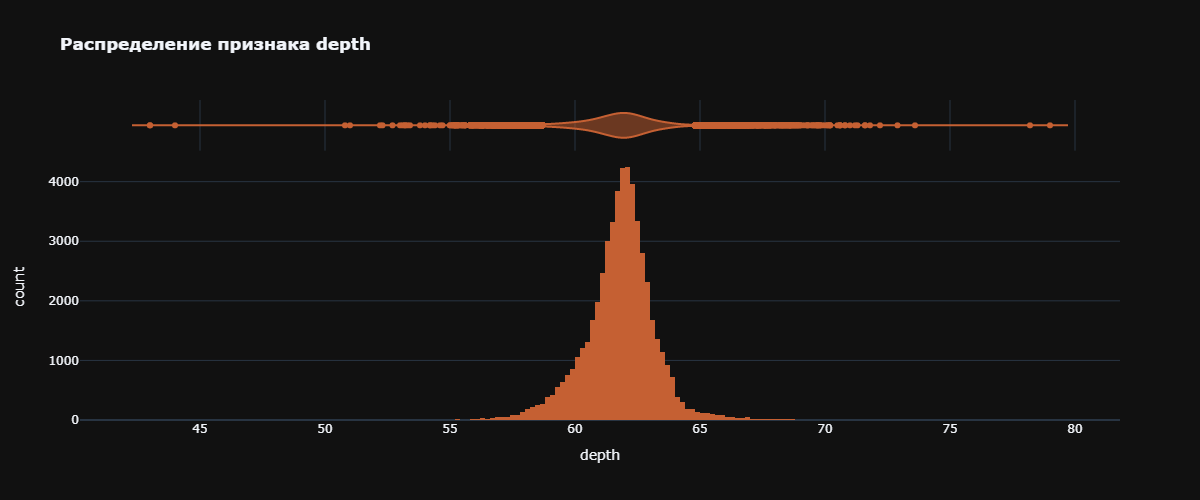

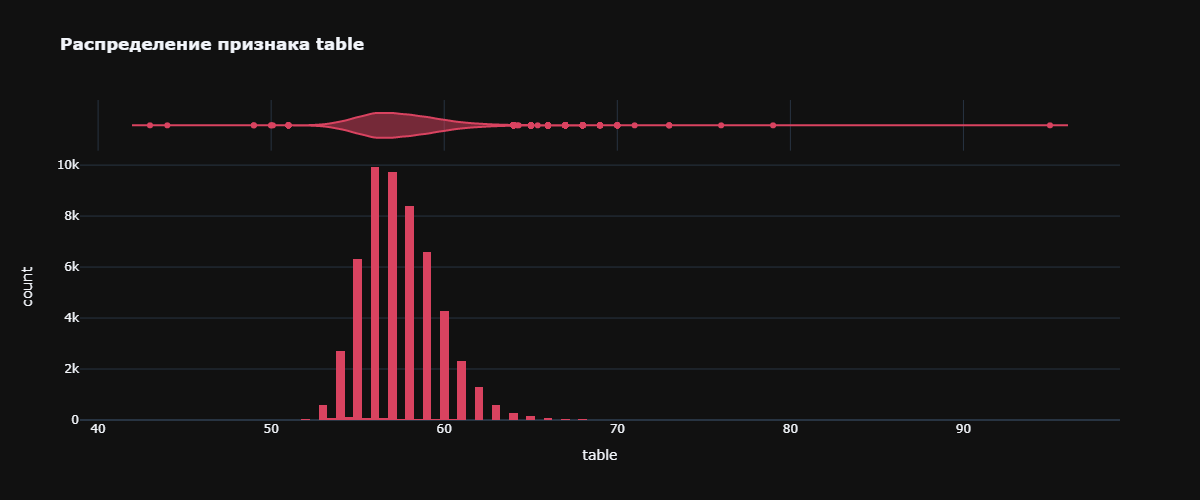

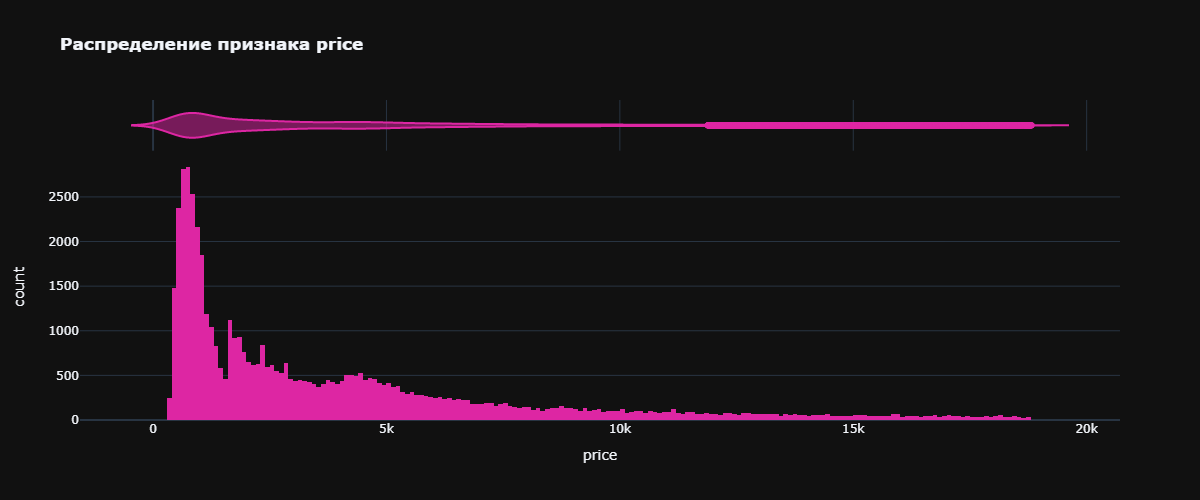

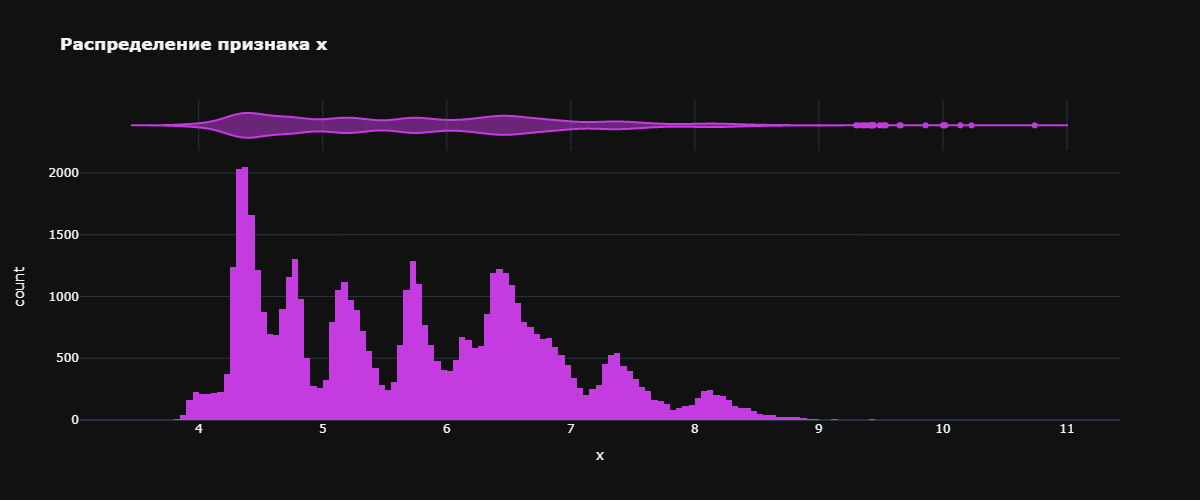

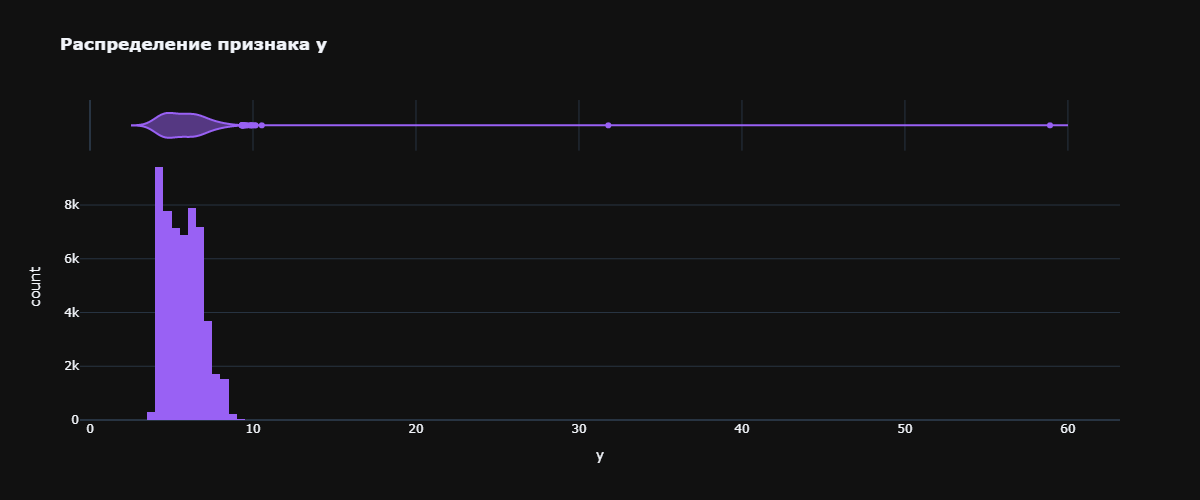

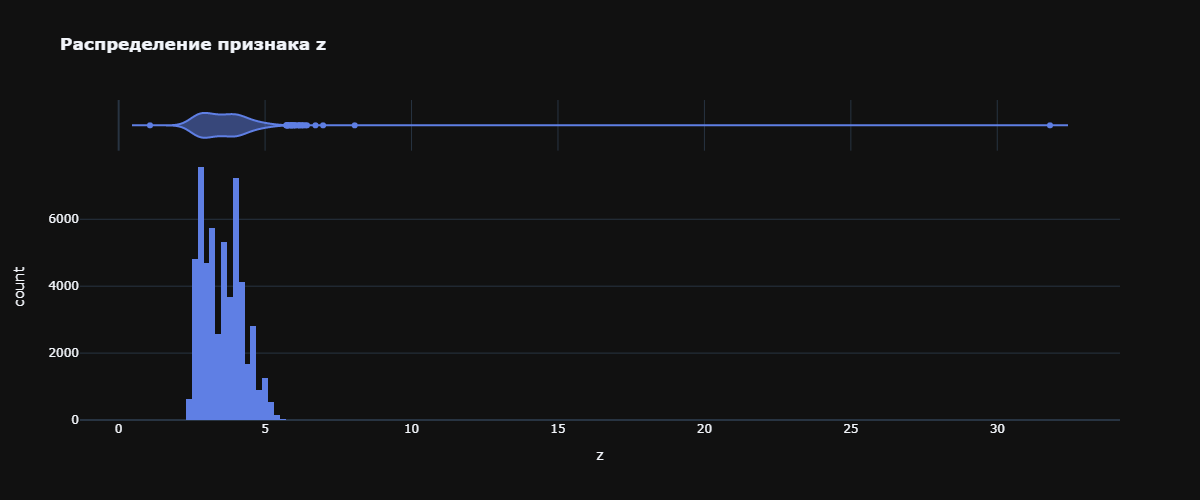

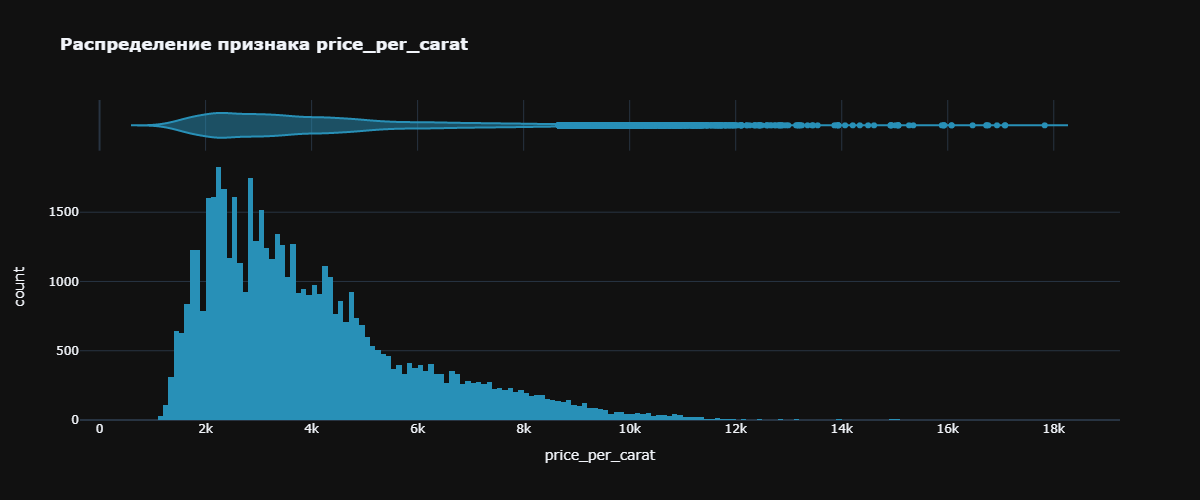

In [6]:
numeric_columns = [column for column in data_copy.columns if data_copy[column].dtype != object]
colors = px.colors.cyclical.Phase[:len(numeric_columns)+1]

for n_col, color in zip(numeric_columns, colors):
    px.histogram(
        data_frame=data_copy,
        x=n_col,
        color_discrete_sequence=[color],
        width=1200,
        height=500,
        title=f'<b>Распределение признака {n_col}</b>',
        marginal='violin',
        nbins=200
    ).show()

Можно заметить, что в нескольких наблюдениях у алмазов есть аномальные размеры. Сложно назвать это именно выбросами, так что оставим пока что подобные набюдения. Если качество моделей будет неудовлетворительным, то можно будет попытаться удалить подобные наблюдения.
***

<a id="categories"></a>

### Распределение категориальных факторов

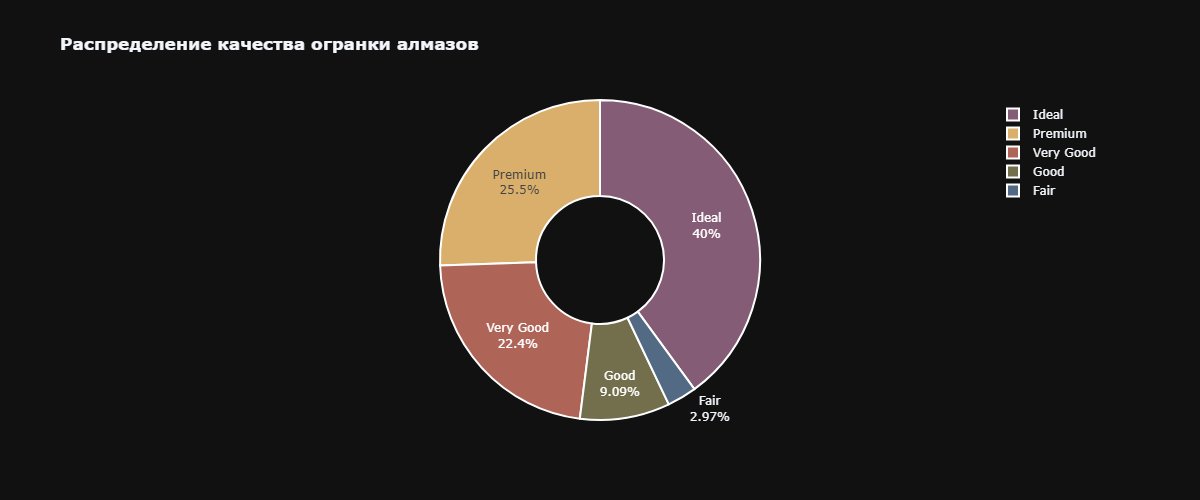

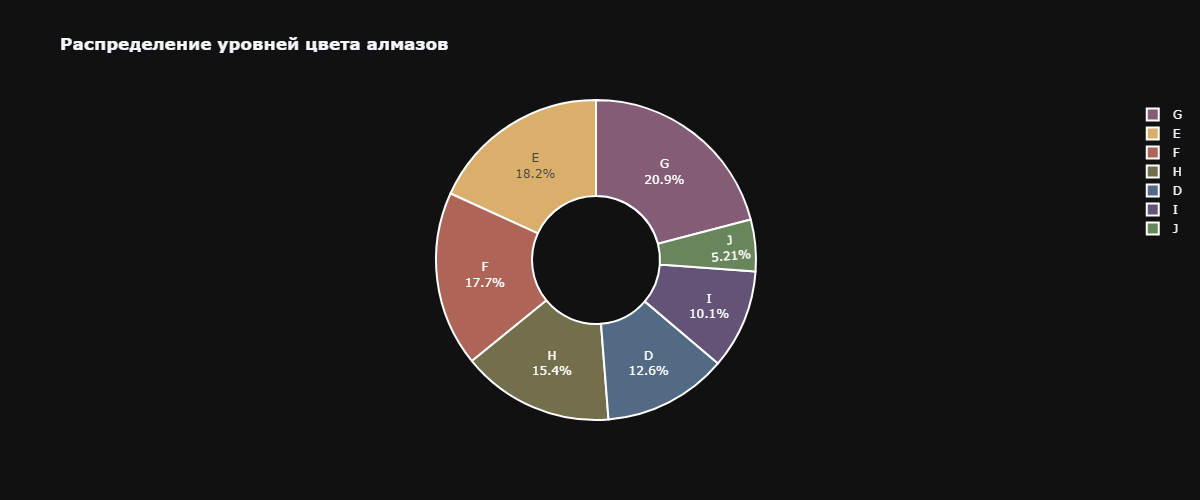

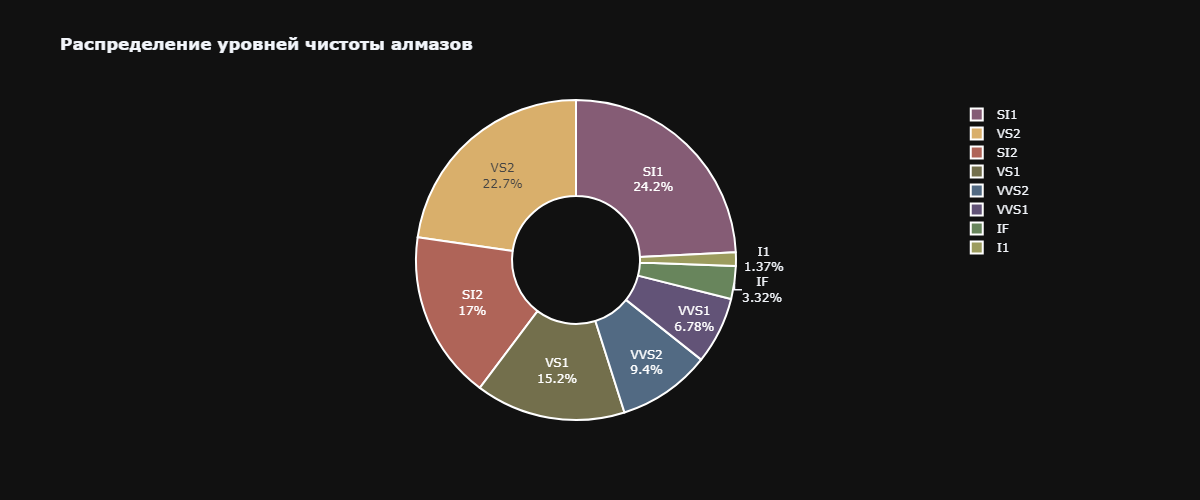

In [7]:
category_columns = [column for column in data.columns if data[column].dtype == object]
titles = [
    '<b>Распределение качества огранки алмазов</b>',
    '<b>Распределение уровней цвета алмазов</b>',
    '<b>Распределение уровней чистоты алмазов</b>'
    ]

for c_col, title in zip(category_columns, titles):
    px.pie(
        names=data[c_col],
        width=1200,
        height=500,
        hole=0.4,
        title=title,
        color_discrete_sequence=px.colors.qualitative.Antique
    ).update_traces(
        textinfo='label+percent',
        marker=dict(line=dict(color='white', width=2))
    ).show()

* В датасете преобладают алмазы идеальной огранки - 40% от всех наблюдений, а самого плохого уровня огранки всего 3%. Есть вероятность, что обученная на таких данных модель может дать неудовлетворительные результаты для алмазов типа `Fair`
* Среди уровней цвета преобладают `E`, `F`, `G`
* Среди чистоты алмазов очень мало наблюдений для уровня `I1` (*Included 1*, худшее качество) и `IF` (*Internally Flawless*, лучшее качество)

***

<a id="price_weight"></a>

### Сравнение зависимости цены алмаза от его веса

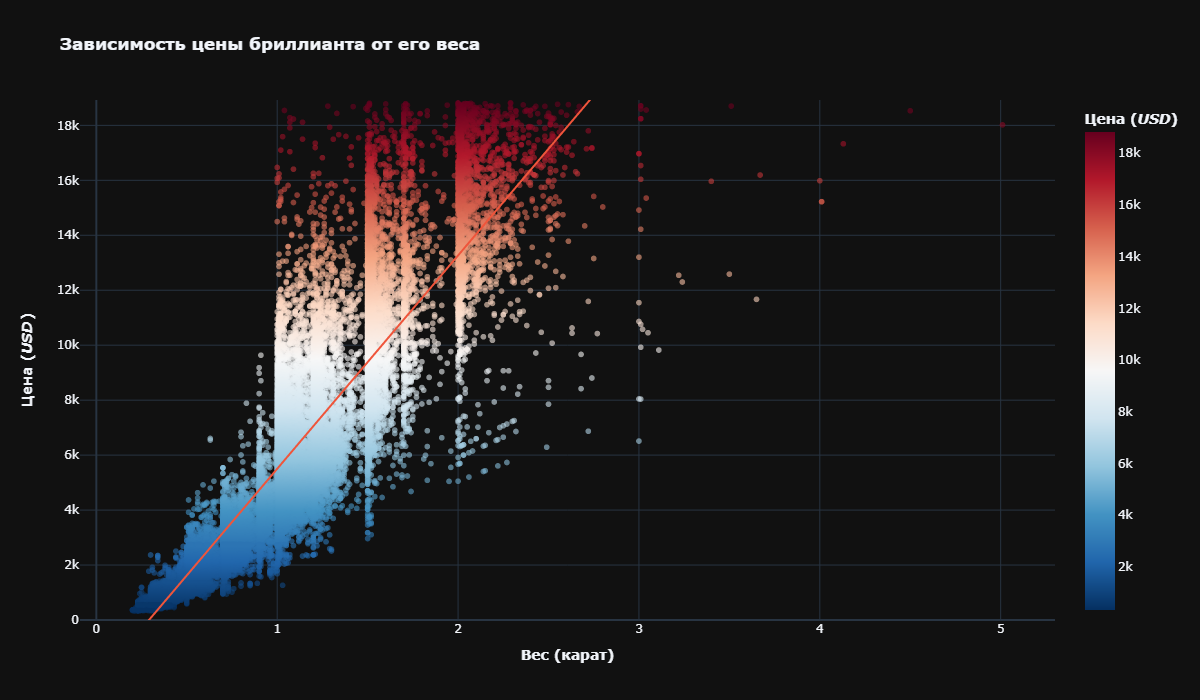

In [8]:
px.scatter(
    data_frame=data,
    y='price',
    x='carat',
    color_continuous_scale=px.colors.diverging.RdBu_r,
    color='price',
    width=1200,
    height=700,
    title='<b>Зависимость цены бриллианта от его веса</b>',
    labels={'price': '<b>Цена (<i>USD</i>)</b>', 'carat': '<b>Вес (карат)</b>'},
    opacity=0.6,
    trendline='ols',
    range_y=[0, data['price'].max() + 1e2]
).show()

Можно сделать логичный вывод - есть очень высокая корреляция между ценой и весом алмаза
***

<a id="price_cut"></a>

### Сравнение средней цены алмаза в зависимости от его качества огранки
>Для сравнения цен будем использовать созданный признак `price_per_carat` (цена за 1 карат), чтобы визуализировать зависимости в данных, не учитывая вес

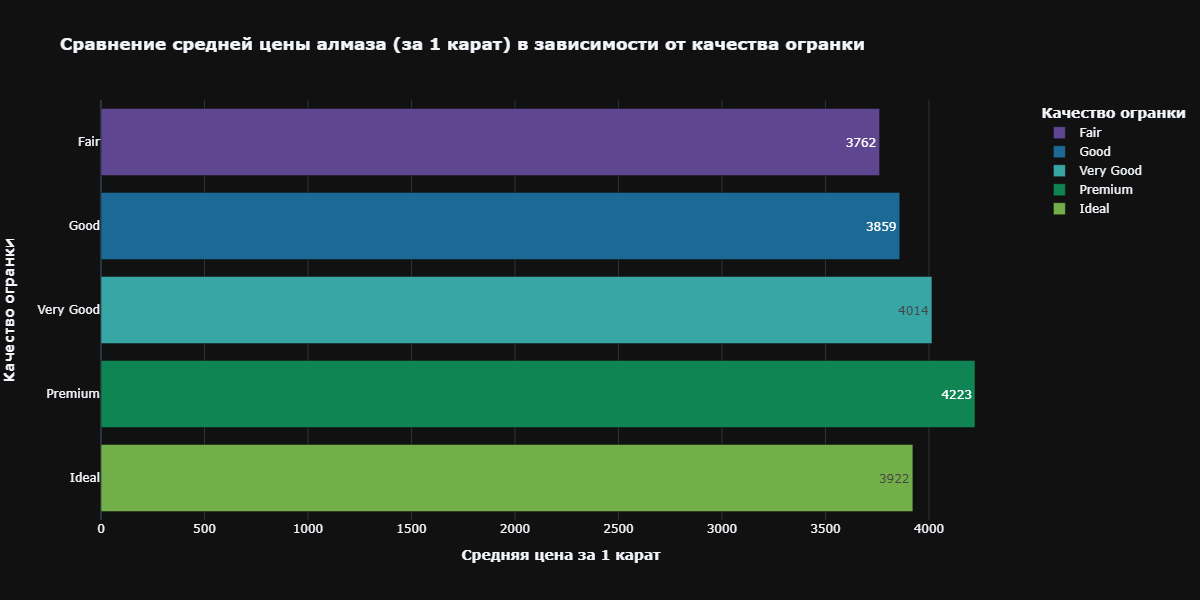

In [9]:
grouped_cut = data_copy.groupby(by='cut', as_index=False)['price_per_carat'].mean()

px.bar(
    grouped_cut,
    x='price_per_carat',
    y='cut',
    width=1200,
    height=600,
    color='cut',
    text_auto='.0f',
    color_discrete_sequence=px.colors.qualitative.Prism,
    category_orders={'cut': ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']},
    labels={'cut': '<b>Качество огранки</b>', 'price_per_carat': '<b>Средняя цена за 1 карат</b>'},
    title='<b>Сравнение средней цены алмаза (за 1 карат) в зависимости от качества огранки</b>'
)

На удивление, в предоставленном датасете наиболее дорогим (за карат) считается алмаз качества огранки *Premium*, а не *Ideal*
***

<a id="price_color"></a>

### Сравнение средней цены алмаза в зависимости от его цвета

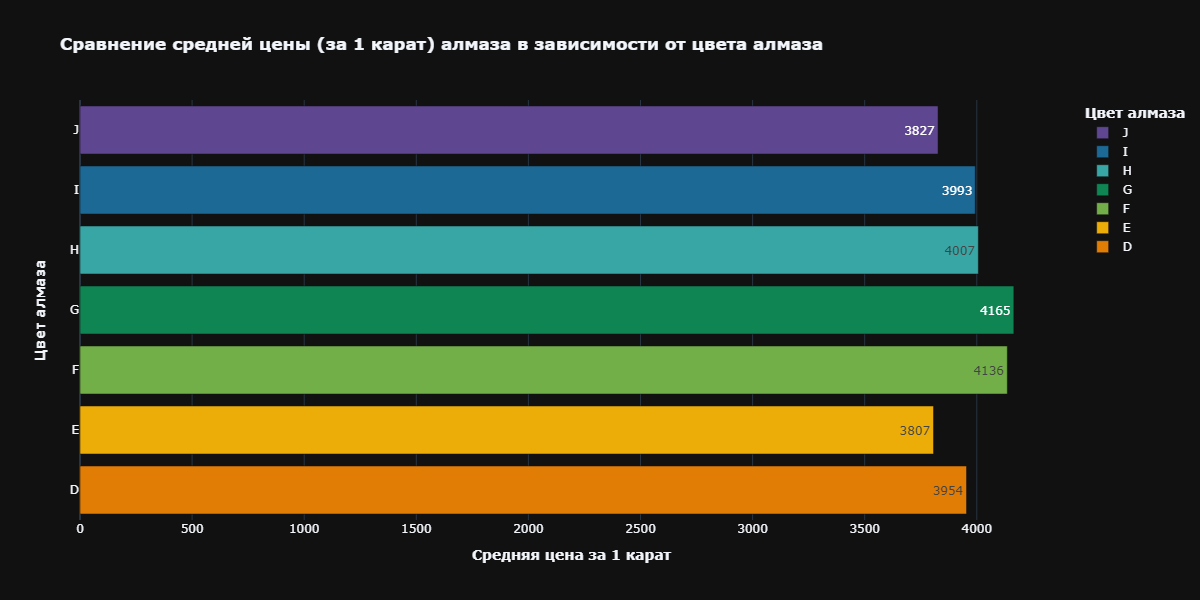

In [10]:
grouped_cut = data_copy.groupby(by='color', as_index=False)['price_per_carat'].mean()

px.bar(
    grouped_cut,
    x='price_per_carat',
    y='color',
    width=1200,
    height=600,
    color='color',
    text_auto='.0f',
    color_discrete_sequence=px.colors.qualitative.Prism,
    category_orders={'color': list(reversed('DEFGHIJ'))},
    labels={'color': '<b>Цвет алмаза</b>', 'price_per_carat': '<b>Средняя цена за 1 карат</b>'},
    title='<b>Сравнение средней цены (за 1 карат) алмаза в зависимости от цвета алмаза</b>'
)

Наиболее дорогими алмазами являются такие, у которых цвет находится "посередине" (средний уровень качества) - *G* и *F*.

***

<a id="cut_clarity"></a>

### Сравнение зависимости средней цены алмаза от его качества огранки и уровня чистоты

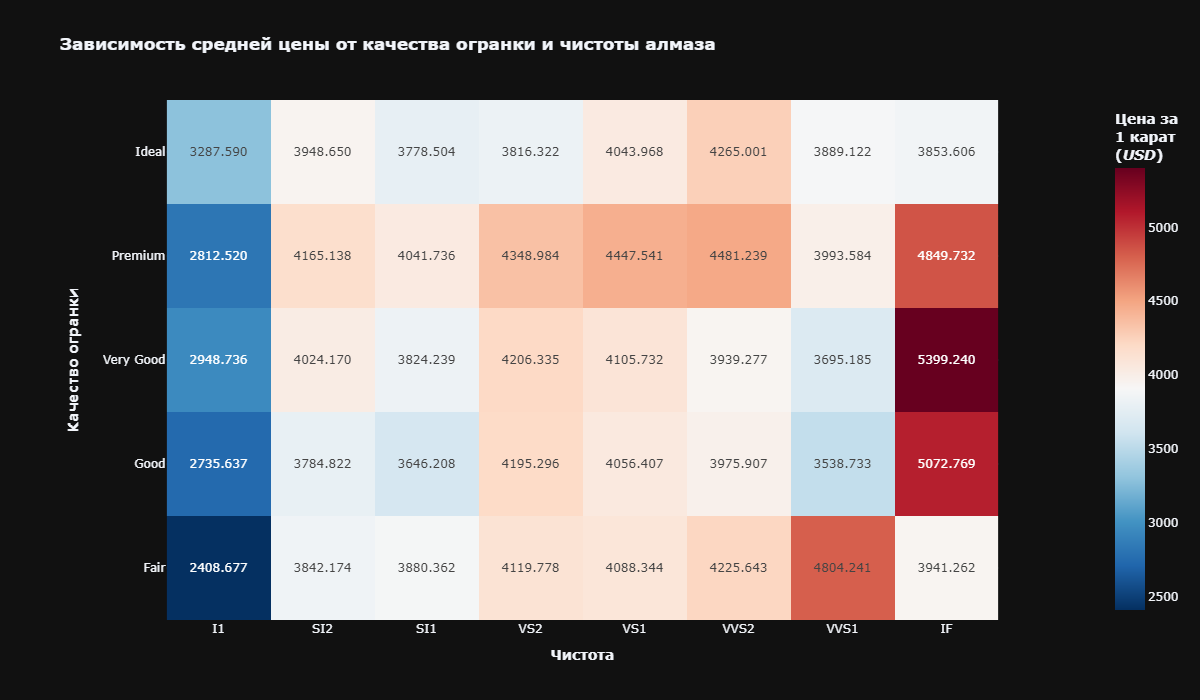

In [11]:
# Порядок качества огранки алмазов
key_cut = {
    'Fair': 0, 
    'Good': 1, 
    'Very Good': 2,
    'Premium': 3, 
    'Ideal': 4
}
# Порядок уровней чистоты алмазов
key_clarity = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
# Сводная таблица
pivot_table = data_copy.pivot_table(
    values='price_per_carat',
    index='cut', 
    columns='clarity',
    aggfunc='mean'
).sort_index(
    key=lambda x: x.map(key_cut),
    ascending=False
)[key_clarity]
# Визуализация сводной таблицы
px.imshow(
    pivot_table,
    width=1200,
    height=700,
    text_auto='.3f',
    color_continuous_scale=px.colors.diverging.RdBu_r,
    title='<b>Зависимость средней цены от качества огранки и чистоты алмаза</b>',
    labels={'y': '<b>Качество огранки</b>', 'x': '<b>Чистота</b>'}
).update_coloraxes(colorbar_title='<b>Цена за<br>1 карат<br>(<i>USD</i>)</b>')

По тепловой карте можно сделать вывод, что на цену больше влияет в первую очередь чистота алмаза, а только потом - качество огранки
***

<a id="weight_cut_clarity"></a>

### Сравнение зависимости веса алмаза от качества огранки и уровня чистоты

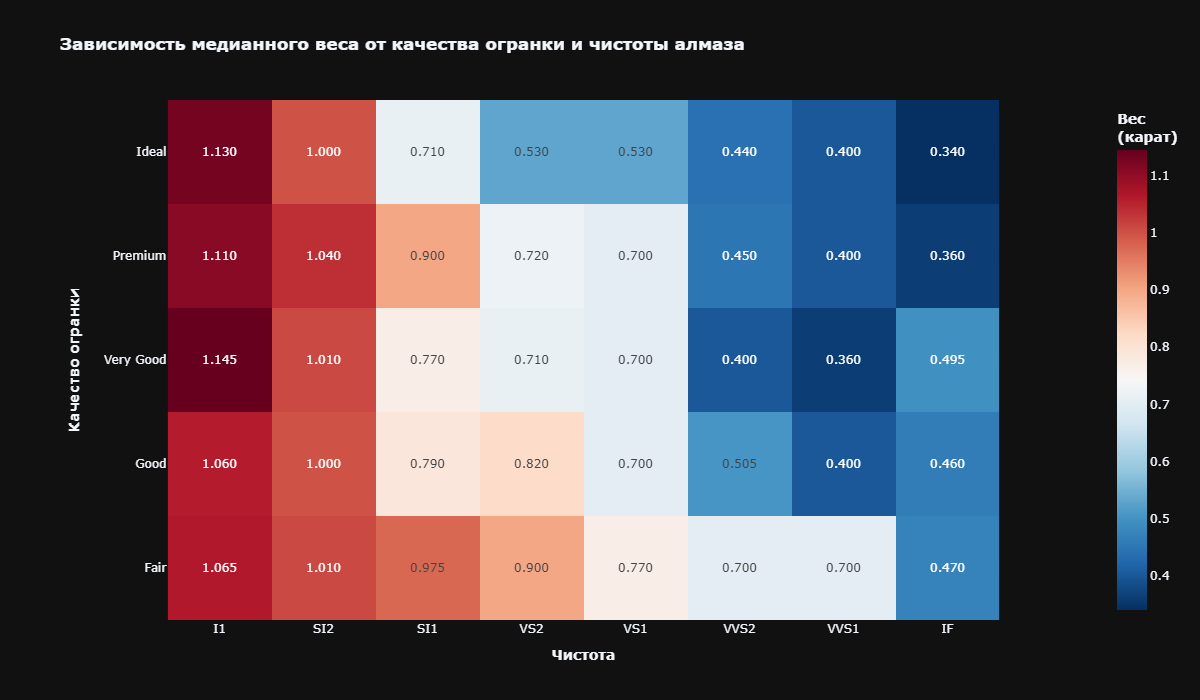

In [12]:
pivot_table = data.pivot_table(
    values='carat',
    index='cut', 
    columns='clarity',
    aggfunc='median'
).sort_index(
    key=lambda x: x.map(key_cut),
    ascending=False
)[key_clarity]
px.imshow(
    pivot_table,
    width=1200,
    height=700,
    text_auto='.3f',
    color_continuous_scale=px.colors.diverging.RdBu_r,
    title='<b>Зависимость медианного веса от качества огранки и чистоты алмаза</b>',
    labels={'y': '<b>Качество огранки</b>', 'x': '<b>Чистота</b>'}
).update_coloraxes(colorbar_title='<b>Вес<br>(карат)</b>')


Наибольший вес имеют алмазы, уровень чистоты которых лежит в пределах от *I1* до *SI1*, то есть не самые удачные образцы. Чем лучше чистота алмаза - тем меньше его вес, при этом качество огранки не так сильно влияет на вес.
***

<a id="count_color_clarity"></a>

### Распределение количества алмазов в датасете в разрезе их цвета и чистоты

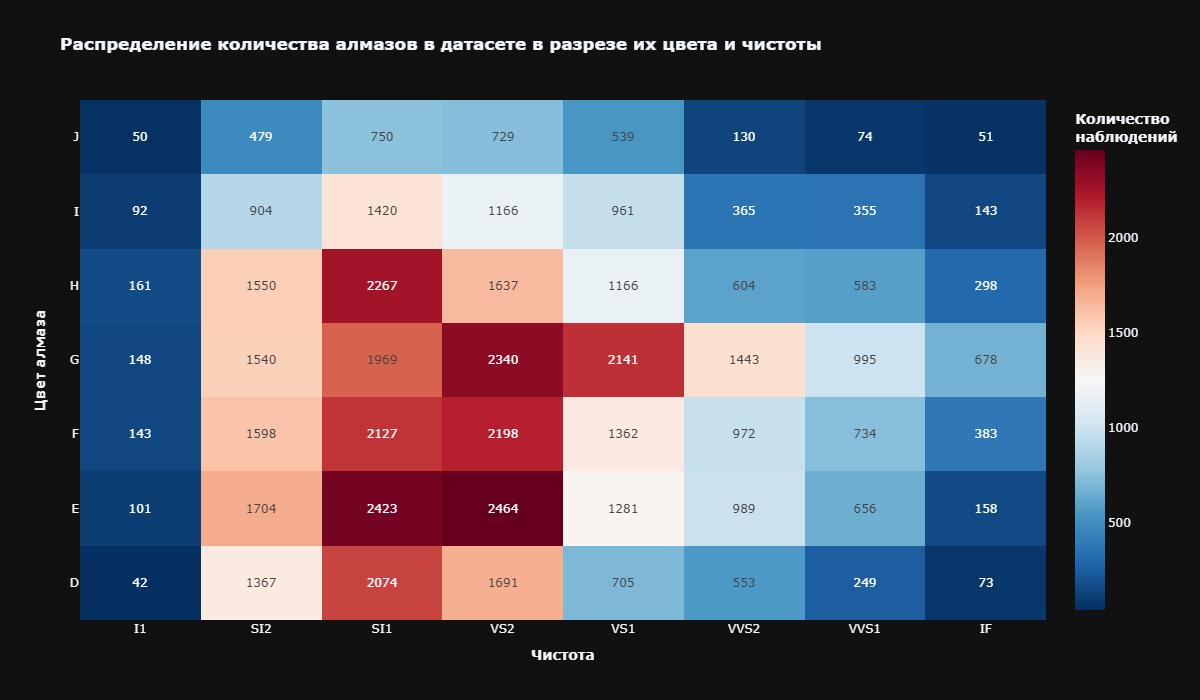

In [13]:
px.density_heatmap(
    data_frame=data_copy,
    x='clarity',
    y='color',
    z='price',
    histfunc='count',
    width=1200,
    height=700,
    category_orders={
        'color': list(reversed('DEFGHIJ')),
        'clarity': key_clarity
    },
    color_continuous_scale=px.colors.diverging.RdBu_r,
    title='<b>Распределение количества алмазов в датасете в разрезе их цвета и чистоты</b>',
    text_auto='.0f',
    labels={'color': '<b>Цвет алмаза', 'clarity': '<b>Чистота</b>'}
).update_coloraxes(colorbar_title='<b>Количество<br>наблюдений</b>')

Больше всего наблюдений сосредоточено в интервале чистоты от *SI2* до *VS1* и цветов от *H* до *E*

***

<a id="stat_tests"></a>

## <center>Статистические тесты</center>
> Так как на цену больше всего влияет вес алмаза, то сравнивать мы будем цену именно за 1 карат для разных групп во всех тестах

<a id="stat_price_clarity"></a>

### Сравнение цены двух групп чистоты *SI2* и *I1*

* **Нулевая гипотеза:** нет разницы между ценой алмазов уровня чистоты *SI2* и *I1*
    $$ \mu_{SI2} \leq \mu_{I1} $$
* **Альтернативная гипотеза:** цена алмазов уровня чистоты *SI2* больше, чем цена алмазов уровня чистоты *I1*
    $$ \mu_{SI2} > \mu_{I1} $$

Зададим уровень значимости $\alpha=0.05$, напишем 2 функции для удобства работы с тестами

In [14]:
# Задаём уровень значимости
alpha = 0.05
# Функция для проверки групп на нормальность
def is_normal(*samples):
    null_hyp = 'распределение является нормальным'
    alt_hyp = 'распределение отлично от нормального'
    for idx, sample in enumerate(samples, start=1):
        _, pvalue = stats.normaltest(sample)
        sample_text = f'Выборка №{idx}: {pvalue=:.3f}, '
        if pvalue <= alpha:
            print(sample_text+alt_hyp)
        else:
            print(sample_text+null_hyp)
# Функция для принятия решения на основе p_value 
def test_hypotesis(pvalue):
    null_hyp = 'Принимаем нулевую гипотезу'
    alt_hyp = 'Отвергаем нулевую гипотезу'
    if pvalue <= alpha:
        print(f'{pvalue=:.3f}\n{alt_hyp}')
    else:
        print(f'{pvalue=:.3f}\n{null_hyp}')

Проверка групп на нормальность

In [15]:
# Фильтруем выборки
price_I1, price_SI2 = [
    data_copy[data_copy['clarity'] == clarity]['price_per_carat']
    for clarity in ['I1', 'SI2']
]
# Проверяем группы на нормальность
is_normal(price_I1, price_SI2)

Выборка №1: pvalue=0.107, распределение является нормальным
Выборка №2: pvalue=0.000, распределение отлично от нормального


2 независимых выборки, распределения не являются нормальным (непараметрический тест), подойдет ***U*-критерий Манна-Уитни**.

In [16]:
_, pvalue = stats.mannwhitneyu(price_SI2, price_I1, alternative='greater')
# Делаем вывод на основе полученного pvalue
test_hypotesis(pvalue)

pvalue=0.000
Отвергаем нулевую гипотезу


>**Вывод:** средняя цена алмазов уровня чистоты *SI2* больше, чем *I1* ( $ \mu_{SI2} > \mu_{I1} $ )
***

<a id="stat_price_cut"></a>

### Существует ли разница в цене алмаза в зависимости от качества огранки
* **Нулевая гипотеза:** нет разницы в средней цене алмазов между группами качества огранки $\{\mu_1, \mu_2, \dots, \mu_n\}$, где $n$ - количество выборок, $\mu$ - средняя цена за 1 карат
    $$ \forall \mu: \mu_i = \mu_j, \text{where} \space i \neq j, \space i=\{1, 2, \dots, n\}, \space j=\{1, 2, \dots, n\} $$
* **Альтернативная гипотеза:** существует разница в средней цене алмаза между группами качества огранки (существует хотя бы одно среднее значение, отличающееся от любой другой выборки)
    $$ \exists \mu: \mu_i \neq \mu_j, \text{where} \space i \neq j, \space i=\{1, 2, \dots, n\}, \space j=\{1, 2, \dots, n\} $$

Проверка групп на нормальность

In [17]:
# Фильтруем выборки
cut_groups = [
    data_copy[data_copy['cut'] == cut_group]['price_per_carat']
    for cut_group in data_copy['cut'].unique()
]
# Делаем тест на нормальность для каждой выборки
is_normal(*cut_groups)

Выборка №1: pvalue=0.000, распределение отлично от нормального
Выборка №2: pvalue=0.000, распределение отлично от нормального
Выборка №3: pvalue=0.000, распределение отлично от нормального
Выборка №4: pvalue=0.000, распределение отлично от нормального
Выборка №5: pvalue=0.000, распределение отлично от нормального


Все группы независимы, имеют распределение, отличное от нормального (непараметрический тест), групп больше двух. Подойдет **Критерий Краскела-Уоллиса**

In [18]:
_, pvalue = stats.kruskal(*cut_groups)
test_hypotesis(pvalue)

pvalue=0.000
Отвергаем нулевую гипотезу


>**Вывод:** существует зависимость средней цены алмаза за 1 карат от качества огранки.
***

<a id="stat_price_clarity_cut"></a>

### Сравнение средней цены алмазов идеальной чистоты (*IF*) между группами с качеством огранки *Good* и *Premium*
* **Нулевая гипотеза:** нет разницы между качеством огранки *Good* и *Premium* для алмазов чистоты *IF*
    $$ \mu(IF)_{Good} = \mu(IF)_{Premium} $$
* **Альтернативная гипотеза:** существует разница между качеством огранки *Good* и *Premium* для алмазов чистоты *IF*
    $$ \mu(IF)_{Good} \neq \mu(IF)_{Premium} $$

Проверка групп на нормальность

In [19]:
# Фильтруем необходимые выборки
IF_groups = [
    data_copy[
        (data_copy['cut'] == cut) 
        & (data_copy['clarity'] == 'IF')
    ]['price_per_carat']
    for cut in ['Good', 'Premium']
]
is_normal(*IF_groups)

Выборка №1: pvalue=0.000, распределение отлично от нормального
Выборка №2: pvalue=0.000, распределение отлично от нормального


2 независимых выборки, распределения не являются нормальным (непараметрический тест), подойдет ***U*-критерий Манна-Уитни**. 

In [20]:
_, pvalue = stats.mannwhitneyu(*IF_groups, alternative='two-sided')
test_hypotesis(pvalue)

pvalue=0.690
Принимаем нулевую гипотезу


>**Вывод:** нет разницы в цене за 1 карат между группами с качеством огранки *Good* и *Premium* для алмазов идеальной чистоты *IF*
***

<a id="stat_clarity_color"></a>

### Существует ли взаимосвязь между чистотой алмаза и его цветом
* **Нулевая гипотеза:** признаки чистоты и цвета независимы
* **Альтернативная гипотеза:** признаки чистоты и цвета взаимосвязаны

Сравниваем 2 категориальных признака. Пойдёт **критерий хи-квадрат** ($\chi^2$)

In [21]:
# Делаем таблицу сопряженности признаков
crosstab_clarity_color = pd.crosstab(index=data_copy['clarity'], columns=data_copy['color'])
pvalue = stats.chi2_contingency(crosstab_clarity_color)[1]
test_hypotesis(pvalue)

pvalue=0.000
Отвергаем нулевую гипотезу


>**Вывод:** признаки чистоты (`clarity`) и цвета (`color`) взаимосвязаны

***

<a id="eda"></a>

## <center>EDA</center>

<a id="eda_encoding"></a>

### Кодирование категориальных признаков
Все категориальные признаки являются порядковыми, поэтому подойдёт следующий класс из библиотеки `sklearn` для кодирования: `OrdinalEncoder`

In [22]:
# Зададим правильный порядок всех категориальных векторов
color_order = list(reversed('DEFGHIJ'))
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
category_columns = ['color', 'clarity', 'cut']
# Инициализируем порядковый энкодер
ord_encoder = OrdinalEncoder(categories=[
    color_order,
    clarity_order,
    cut_order
])
# Создадим копию изначального датафрейма, чтобы трансформировать данные и визуализировать матрицу корреляции
data_encoded = data.copy()
data_encoded[category_columns] = ord_encoder.fit_transform(data[category_columns])

***

<a id="eda_corr_matrix"></a>

### Матрица корреляции
Так как в данных есть как непрерывные, так и категориальные признаки, то посмотрим на 2 разных метода корреляции - Пирсона и Спирмана

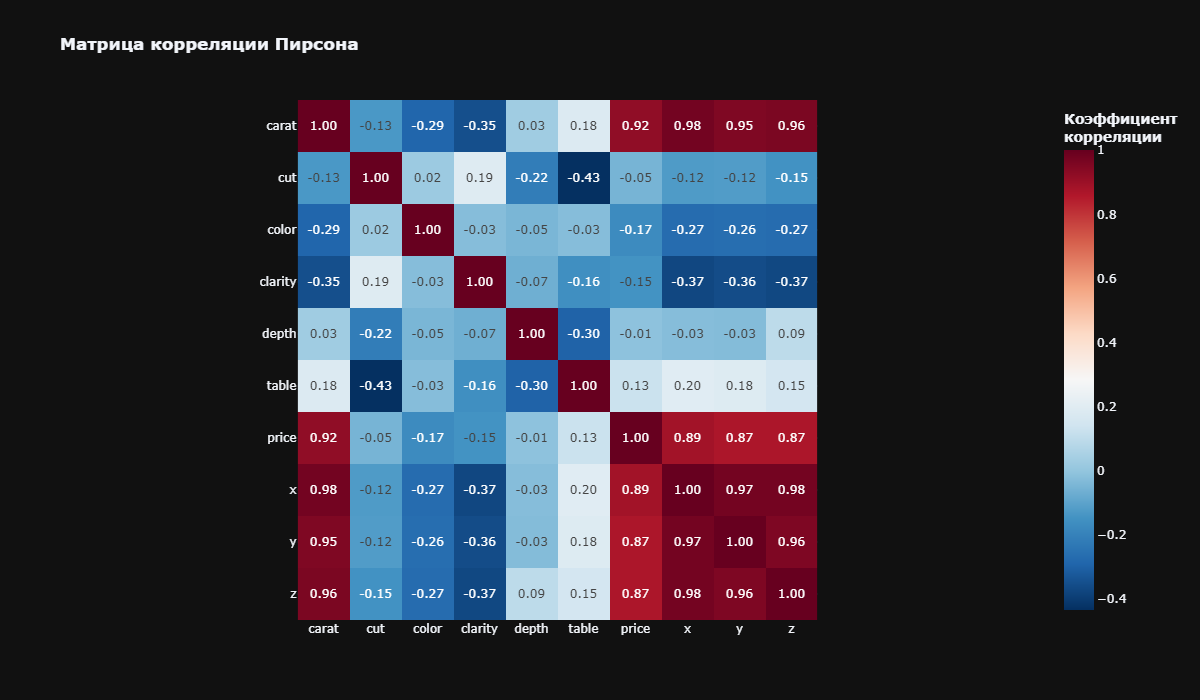

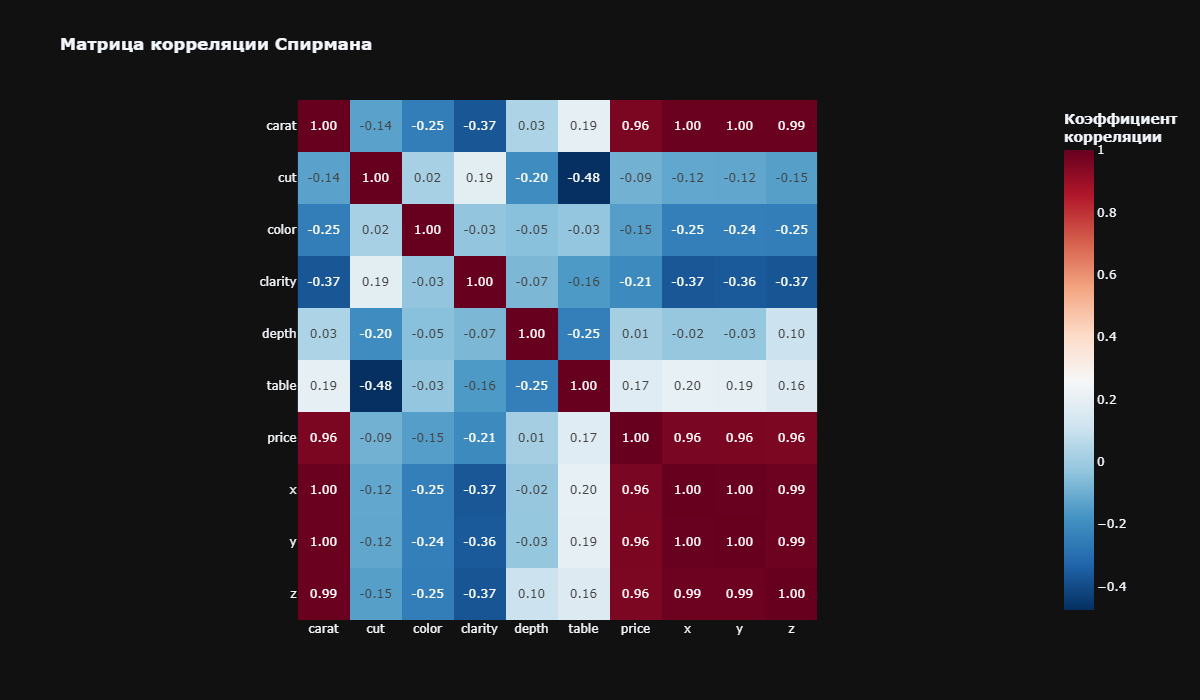

In [23]:
px.imshow(
    data_encoded.corr(),
    width=1200,
    height=700,
    text_auto='.2f',
    color_continuous_scale=px.colors.diverging.RdBu_r,
    title='<b>Матрица корреляции Пирсона</b>'
).update_coloraxes(colorbar_title='<b>Коэффициент<br>корреляции</b>').show()

px.imshow(
    data_encoded.corr(method='spearman'),
    width=1200,
    height=700,
    text_auto='.2f',
    color_continuous_scale=px.colors.diverging.RdBu_r,
    title='<b>Матрица корреляции Спирмана</b>'
).update_coloraxes(colorbar_title='<b>Коэффициент<br>корреляции</b>').show()

Видно, что `x`, `y`, `z` и `carat` - один и тот же признак (очевидно, что **вес линейно зависим от размеров**). Можно удалить эти признаки. Однако, цена (целевой признак) слишком сильно коррелирует с весом. Для начала изменим целевой признак так, чтобы он показывал **цену алмаза за 1 карат**. Таким образом, мы сможем удалить в том числе и признак `carat`. В предсказаниях же мы будем делать поэлементное умножение двух векторов - вектора предсказаний и признака `carat`, тем самым получая предсказания, которые учитывают вес.

Если метод, описанный выше, покажет плохое качество, то будем использовать другой подход, в котором признак `carat` уже будет учавствовать

Посмотрим на корреляции признаков с целевым (без учета веса)

In [24]:
drop_columns = ['x', 'y', 'z', 'carat', 'price']

data_encoded['price_per_carat'] = data_encoded['price'] / data_encoded['carat']

data_encoded.drop(columns=drop_columns, inplace=True)
data_encoded.sample(3, random_state=RANDOM_STATE)

,cut,color,clarity,depth,table,price_per_carat
32547,4.0,6.0,6.0,61.9,57.0,2959.259259
2677,2.0,6.0,4.0,61.5,55.0,4627.142857
22910,3.0,2.0,3.0,60.2,60.0,7252.317881


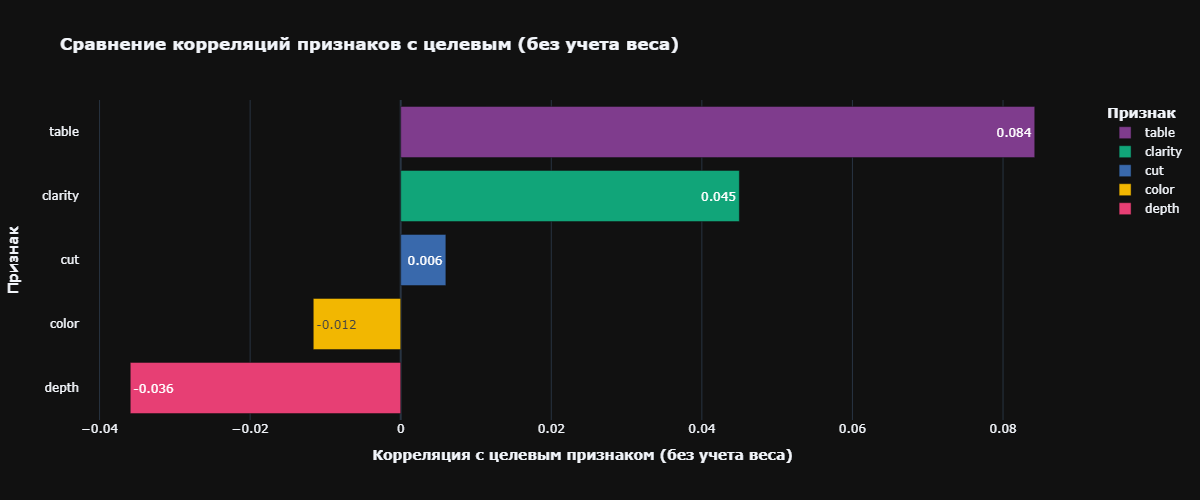

In [42]:
target_corr = data_encoded.corr().iloc[:-1, -1].sort_values(ascending=False).reset_index().rename(columns={'index': 'feature', 'price_per_carat': 'corr'})

px.bar(
    data_frame=target_corr,
    x='corr',
    y='feature',
    width=1200,
    height=500,
    color='feature',
    color_discrete_sequence=px.colors.qualitative.Bold,
    labels={'corr': '<b>Корреляция с целевым признаком (без учета веса)</b>', 'feature': '<b>Признак</b>'},
    title='<b>Сравнение корреляций признаков с целевым (без учета веса)</b>',
    text_auto='.3f'
)

Можно заметить, что значения корреляции очень низкие, если не учитывать вес. Возможно, тут существует нелинейная зависимость, либо её нет вовсе, и ни одна модель не сможет обучиться на такой выборке.

***

<a id="ml_without_weight"></a>

## <center>Machine Learning (предсказание целевого признака без учета веса)</center>

<a id="ml_start"></a>

### Выбор метрики, разделение данных на обучающую и тестовую выборки
В качестве метрики возьмем $MAPE$

Разделим выборку на обучающую и тестовую в соотношениии 70% к 30%

In [50]:
# Создаем целевой признак
data['price_per_carat'] = data['price'] / data['carat']
# X - матрица наблюдений, y - целевой признак
X, y = data.drop(columns=['price', 'carat', 'price_per_carat']), data['price_per_carat']
# Могли появиться дубликаты в выборке X, удалим их
X.drop_duplicates(inplace=True)
y = y[X.index]
# Разделяем выборки на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
# Отображаем информацию
print(
    f'Размер обучающей выборки: {X_train.shape}\n',
    f'Размер тестовой выборки: {X_test.shape}',
    end='', 
    sep=''
)
display(Markdown('Пример выборки `X_train`'))
display(X_train.sample(3, random_state=RANDOM_STATE))

Размер обучающей выборки: (37456, 8)
Размер тестовой выборки: (16053, 8)

Пример выборки `X_train`

,cut,color,clarity,depth,table,x,y,z
41501,Premium,F,SI2,59.1,58.0,5.60,5.57,3.30
8610,Good,E,SI1,63.7,62.0,6.31,6.40,4.05
31336,Ideal,G,SI1,61.9,54.0,4.77,4.82,2.97


***

<a id="ml_preprocessing"></a>

### Создание пайплайна предобработки данных
Удаляем признаки `x`, `y`, `z` из-за очень высокой корреляции. Категориальные признаки кодируем в определенном порядке с помощью `OrdinalEncoder`, а к числовым используем `RobustScaler`, который менее подвержен влиянию выбросов, т.к. мы не очищали данные от выбросов

In [49]:
column_pipeline = make_column_transformer(
    ('drop', ['x', 'y', 'z']),
    (ord_encoder, ['color', 'clarity', 'cut']),
    (RobustScaler(), ['depth', 'table'])
)
column_pipeline

ColumnTransformer(transformers=[('drop', 'drop', ['x', 'y', 'z']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['J', 'I', 'H', 'G',
                                                             'F', 'E', 'D'],
                                                            ['I1', 'SI2', 'SI1',
                                                             'VS2', 'VS1',
                                                             'VVS2', 'VVS1',
                                                             'IF'],
                                                            ['Fair', 'Good',
                                                             'Very Good',
                                                             'Premium',
                                                             'Ideal']]),
                                 ['color', 'clarity', 'cut']),
                                ('robustscaler', RobustScaler(),
                                 ['depth', 'table'])])

***

<a id="ml_lr"></a>

### *LinearRegression*
<img src=../img/linear_regression.png></img>

Для начала напишем функцию, которая будет отображать метрики для моделей, а так же записывать все результаты в словарь (можно будет визуально сравнить качество моделей)

In [51]:
# Будем хранить метрики всех моделей в одном словаре
metrics_dict = {
    'model': [],
    'metric': [],
    'sample': []
}
# Функция, которая записывает метрики каждого пайплайна в словарь, а также выводит значение MAPE исследуемых моделей
def print_metrics(*pipelines):
    for pipeline in pipelines:
        # Делаем предсказания для выборок и вычисляем метрики
        y_pred_train = pipeline.fit(X_train, y_train).predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
        mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
        # Имя модели
        model_name = pipeline[-1].__class__.__name__
        # Записываем в словарь все данные о метриках модели
        metrics_dict['model'].extend([model_name, model_name])
        metrics_dict['metric'].extend([mape_train, mape_test])
        metrics_dict['sample'].extend(['train', 'test'])
        # Отображаем информацию для конкретной модели
        display(Markdown(
            f'Значение метрики $MAPE$ при использовании *{model_name}*:<br> \
            <ul><li>train: ${mape_train:.3f}$</li><li>test: ${mape_test:.3f}$</li></ul>'
        ))

В качестве первых двух простых моделей возьмем линейную регрессию и дерево решений глубины 7

In [52]:
# Создание пайплайна линейной регрессии
lr_pipeline = make_pipeline(
    column_pipeline,
    LinearRegression()
)
# Выведем значение целевой метрики
print_metrics(lr_pipeline)

Значение метрики $MAPE$ при использовании *LinearRegression*:<br>             <ul><li>train: $0.473$</li><li>test: $0.474$</li></ul>

<a id="ml_dt"></a>

### *DecisionTreeRegressor*
<img src=../img/decision_tree.jpg></img>

In [53]:
# Пайплайн одного решающего дерева глубины 7
dt_pipeline = make_pipeline(
    column_pipeline,
    DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=7)
)
print_metrics(dt_pipeline)

Значение метрики $MAPE$ при использовании *DecisionTreeRegressor*:<br>             <ul><li>train: $0.454$</li><li>test: $0.461$</li></ul>

Оба варианта показали примерно одинаковый результат. Начнем с модернизации линейной регресии

Попробуем уменьшить смещение (*bias*) линейной регрессии с помощью добавления **полиномиальной зависимости**
***

<a id="ml_lr_pf"></a>

### *LinearRegression & PolynomialFeatures*
<img src=../img/polynomial_regression.png></img>

Возьмем полином 3-ей степени

In [30]:
poly_transformer = PolynomialFeatures(degree=3, include_bias=False)
poly_lr_pipeline = make_pipeline(
    column_pipeline,
    poly_transformer,
    LinearRegression()
)
print_metrics(poly_lr_pipeline)

Значение метрики $MAPE$ при использовании *LinearRegression*:<br>             <ul><li>train: $0.463$</li><li>test: $0.466$</li></ul>

Метрика практически не поменялась, поэтому перейдем к поиску гиперпараметров одного решающего дерева, который показал результат немного лучше, чем линейная регрессия
***

<a id="ml_dt_optuna"></a>

### *DecisionTreeRegressor* (с подбором гиперпараметров)
Для начала напишем функцию, чтобы её можно было использовать для любого пайплайна, она принимает следующие аргументы:
* `pipeline` - пайплайн с предобработкой данных и самой моделью
* `n_trials` - количество итераций для поиска гиперпараметров
* `optimize_params` - словарь из гиперпараметров модели, которые необходимо подбирать. Ключ - название гиперпараметра, значение - массив `numpy` с соответствующим `dtype` (`str`, `int` или `float`)
* `default_params` - словарь из гиперпараметров модели, которые заданы констаной изначально (например, `random_state` или `n_jobs`)
* `cv` - количество фолдов кросс-валидации, по-умолчанию равно `5`
* `direction` - направление оптимизации, по-умолчанию равно `minimize`
* `n_jobs` - количество используемых ядер процессора, по-умолчанию `-1` (все ядра)

Функция возвращает объединенный словарь из подобранных гиперпараметров и тех, что были изначально константой

In [31]:
def get_best_hyperparameters(
    pipeline:Pipeline,
    n_trials:int, 
    optimize_params:dict,
    default_params:dict,
    cv=5,
    direction='minimize',
    n_jobs=-1
) -> dict:
    
    """Функция возвращает наилучшие гиперпараметры для модели, подобранные с помощью optuna на кросс-валидации

    Args:
        pipeline (BaseEstimator): пайплайн с моделью
        
        n_trials (int): количество итераций
        
        optimize_params (dict): словарь из подбираемых гиперпараметров
        
        default_params (dict): словарь из гиперпараметров, заданных константой
        
        cv (int, optional): количество фолдов кросс-валидации. Defaults to 5.
        
        direction (str, optional): направление оптимизации. Defaults to 'minimize'.
        
        n_jobs (int, optional): количество используемых ядер процессора. Defaults to -1.

    Returns:
        dict: объединенный словарь из наилучших и константных гиперпараметров
    """
    
    # Изменяем словарь константных параметров таким образом, 
    # чтобы его можно было подать в метод .set_params() объекта Pipeline
    tuned_default_params = dict()
    for param, value in default_params.items():
        param_name = pipeline[-1].__class__.__name__.lower() + '__' + param
        tuned_default_params[param_name] = value
    
    def objective(trial:Trial) -> float:
        # Изменяем словарь оптимизируемых параметров 
        tuned_optimize_params = dict()
        for param, value in optimize_params.items():
            param_name = pipeline[-1].__class__.__name__.lower() + '__' + param
            param_type = value.dtype
            if param_type == object:
                tuned_optimize_params[param_name] = trial.suggest_categorical(name=param_name, choices=value)
            elif param_type == int:
                tuned_optimize_params[param_name] = trial.suggest_int(name=param_name, low=value[0], high=value[1])
            elif param_type == float:
                tuned_optimize_params[param_name] = trial.suggest_float(name=param_name, low=value[0], high=value[1])
        # Создаем пайплайн и задаём гиперпараметры
        tuned_pipeline = pipeline.set_params(**tuned_optimize_params, **tuned_default_params)
        # Кросс валидация для поиска гиперпараметров на валидационной выборке, а не обучающей
        score = cross_val_score(
            tuned_pipeline,
            X_train,
            y_train,
            cv=cv, 
            scoring=make_scorer(mean_absolute_percentage_error),
            n_jobs=n_jobs
        ).mean()
        # Возвращаем метрику с кросс валидации
        return score
    # Поиск оптимальных гиперпараметров на n итерациях
    model_name = pipeline[-1].__class__.__name__
    study = optuna.create_study(study_name=model_name, direction=direction)
    start_time = time.time()
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    end_time = time.time()
    # Визуализация истории оптимизации и значимости каждого параметра
    optuna.visualization.plot_optimization_history(study).update_layout(width=1200, height=500).show('png')
    optuna.visualization.plot_param_importances(study).update_layout(width=1200, height=500).show('png')
    # Выведем время выполнения
    total_time = end_time - start_time
    minutes = int(total_time // 60)
    seconds = int(round(total_time % 60, 0))
    display(Markdown(
        f'##### Оптимизация заняла ${minutes}$ минут(-ы) ${seconds}$ секунд(-ы)<p> \
        Наилучшее значение метрики $MAPE$ на кросс-валидации: ${study.best_value:.3f}$'
    ))
    # Объединяем константные гиперпараметры с подобранными и возвращаем их
    tuned_default_params.update(study.best_params)
    display(Markdown(f'##### Подобранные гиперпараметры для *{model_name}*:'))
    display(tuned_default_params)
    return tuned_default_params

Используем написанную функцию для оптимизации одного решающего дерева

  0%|          | 0/30 [00:00<?, ?it/s]

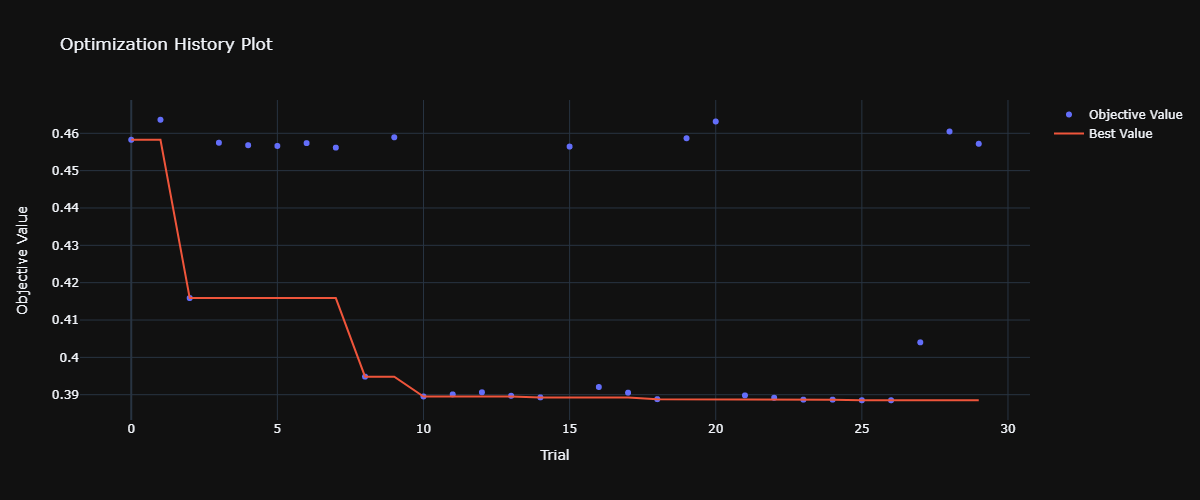

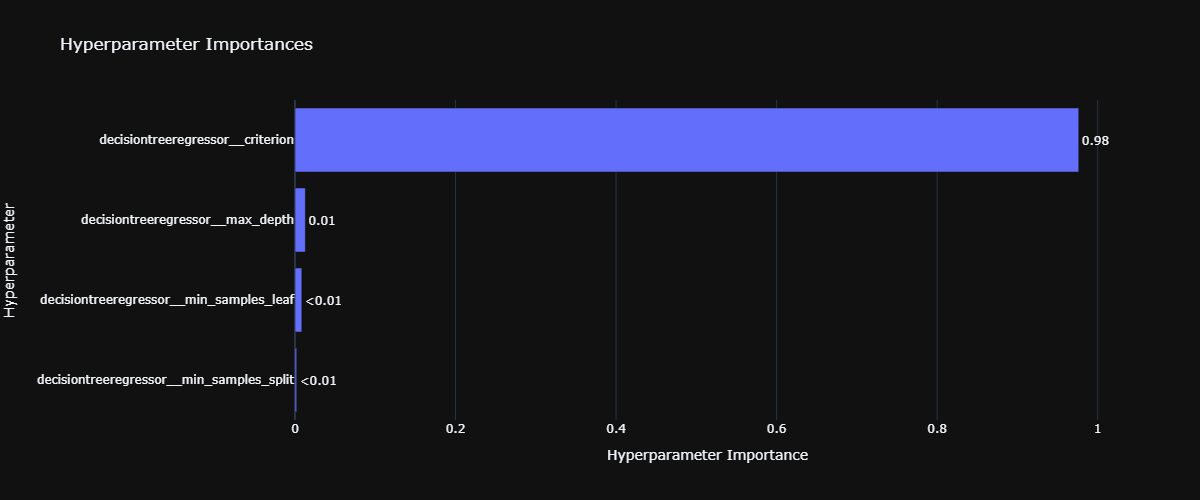

##### Оптимизация заняла $3$ минут(-ы) $29$ секунд(-ы)<p>         Наилучшее значение метрики $MAPE$ на кросс-валидации: $0.389$

##### Подобранные гиперпараметры для *DecisionTreeRegressor*:

{'decisiontreeregressor__random_state': 42,
 'decisiontreeregressor__criterion': 'absolute_error',
 'decisiontreeregressor__max_depth': 7,
 'decisiontreeregressor__min_samples_split': 28,
 'decisiontreeregressor__min_samples_leaf': 15}

In [32]:
# Гиперпараметры для оптимизации
dt_optimize_params = dict(
    # критерий информативности
    criterion=np.array(['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], dtype=object),
    # максимальная глубина дерева
    max_depth=np.array([5, 20], dtype=int),
    # минимальное количество объектов, при которых допускается ветвление дерева 
    min_samples_split=np.array([2, 30], dtype=int),
    # минимальное количество объектов, необходимых для создания листа
    min_samples_leaf=np.array([1, 30], dtype=int),
)
# Гиперпараметры, заданные константой
dt_default_params = dict(
    # случайная инициализация
    random_state=RANDOM_STATE
)
# Создание пайплайна одного дерева
dt_pipeline = make_pipeline(
    column_pipeline,
    DecisionTreeRegressor()
)
# Ищем наилучшие гиперпараметры на 30 итерациях
best_dt_params = get_best_hyperparameters(
    dt_pipeline,
    n_trials=30,
    optimize_params=dt_optimize_params,
    default_params=dt_default_params,
    n_jobs=-1,
    cv=5
)

Выведем метрики на `train` и `test` для дерева с подобранными гиперпараметрами

In [33]:
# Устанавливаем подобранные параметры и выводим метрики
dt_pipeline = dt_pipeline.set_params(**best_dt_params)
print_metrics(dt_pipeline)

Значение метрики $MAPE$ при использовании *DecisionTreeRegressor*:<br>             <ul><li>train: $0.382$</li><li>test: $0.388$</li></ul>

Напишем функцию для определения значимости признаков для моделей, основанных на деревьях решений

In [34]:
def display_feature_importances(pipeline:Pipeline):
    # Делаем датафрейм из двух столбцов: признак и значимость. Сортируем по значимости
    features_df = pd.DataFrame({
        'feature': pipeline[0].get_feature_names_out(),
        'importance': pipeline[-1].feature_importances_
    }).sort_values(by='importance', ascending=False)
    # Убираем название модели из названия признака
    features_df['feature'] = features_df['feature'].apply(lambda feature: feature.split('__')[-1])
    model_name = pipeline[-1].__class__.__name__
    # Строим график
    px.bar(
        data_frame=features_df,
        x='importance',
        y='feature',
        color='feature',
        width=900,
        height=600,
        text_auto='.2f',
        color_discrete_sequence=px.colors.qualitative.Pastel,
        title=f'<b>Значимость признаков модели <i>{model_name}</i></b>',
        labels={'feature': '<b>Признак</b>', 'importance': '<b>Коэффициент значимости (от 0 до 1)</b>'}
    ).show()

Отобразим значимость каждого признака для одного решающего дерева

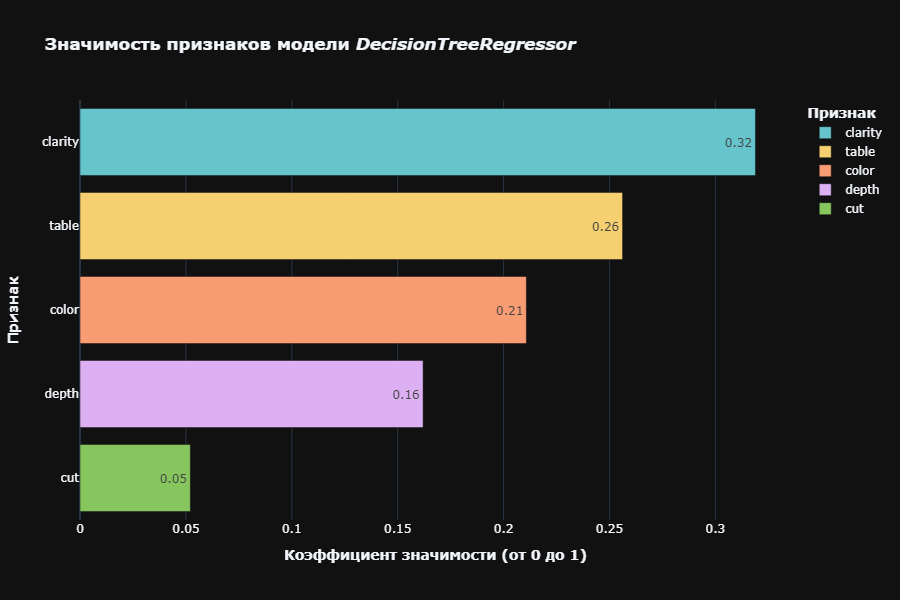

In [35]:
display_feature_importances(dt_pipeline)

Итак, получилось уменьшить метрику с $0.46$ (*LinearRegression*) до $0.39$ (*DecisionTreeRegressor*). Можно попробовать использовать случайный лес, раз одно дерево показывает небольшое улучшение метрики в сравнении с линейной регрессией

***

<a id="ml_rf"></a>

### *RandomForestRegressor*
<img src=../img/random_forest.png></img>

  0%|          | 0/20 [00:00<?, ?it/s]

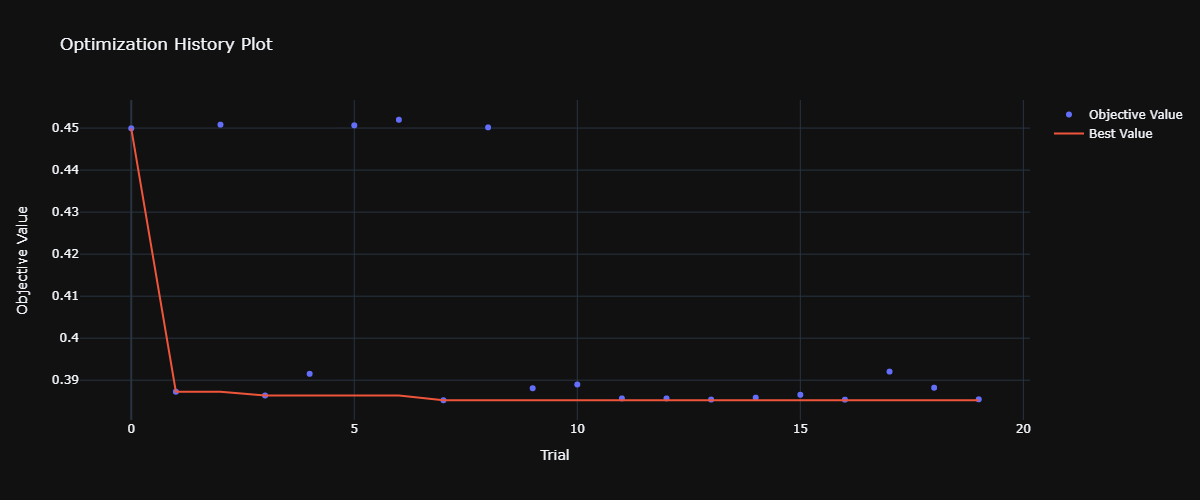

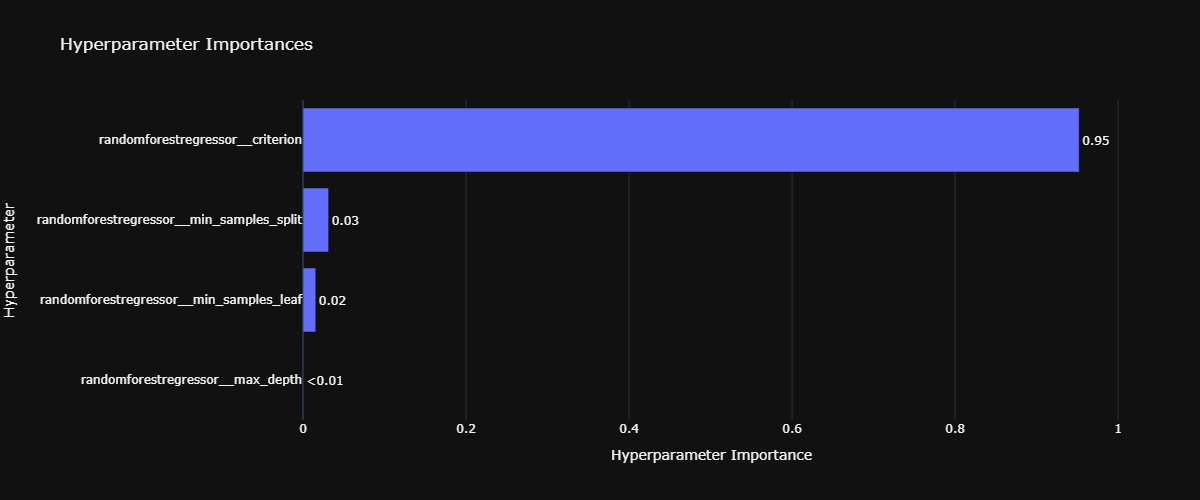

##### Оптимизация заняла $16$ минут(-ы) $8$ секунд(-ы)<p>         Наилучшее значение метрики $MAPE$ на кросс-валидации: $0.385$

##### Подобранные гиперпараметры для *RandomForestRegressor*:

{'randomforestregressor__random_state': 42,
 'randomforestregressor__n_jobs': -1,
 'randomforestregressor__n_estimators': 50,
 'randomforestregressor__criterion': 'absolute_error',
 'randomforestregressor__max_depth': 8,
 'randomforestregressor__min_samples_split': 4,
 'randomforestregressor__min_samples_leaf': 9}

In [36]:
# Параметры, заданные константой
rf_default_params = dict(
    # случайная инициализация
    random_state=RANDOM_STATE,
    # количество используемых ядер процессора
    n_jobs=-1,
    # количество деревьев в лесу
    n_estimators=50
)
# Параметры, которые будем подбирать
rf_optimize_params = dict(
    # критерий информативности
    criterion=np.array(['squared_error', 'absolute_error'], dtype=object),
    # максимальная глубина каждого дерева
    max_depth=np.array([8, 20], dtype=int),
    # минимальное количество объектов, при которых допускается ветвление дерева
    min_samples_split=np.array([2, 30], dtype=int),
    # минимальное количество объектов, необходимых для создания листа
    min_samples_leaf=np.array([1, 30], dtype=int)
)
# Создаем пайплайн
rf_pipeline = make_pipeline(
    column_pipeline,
    RandomForestRegressor()
)
# Ищем наилучшие гиперпараметры на 20 итерациях
best_rf_params = get_best_hyperparameters(
    pipeline=rf_pipeline,
    n_trials=20,
    optimize_params=rf_optimize_params,
    default_params=rf_default_params,
    cv=3
)

In [37]:
# Устанавливаем найденные гиперпараметры и выводим метрики
rf_pipeline = rf_pipeline.set_params(**best_rf_params)
print_metrics(rf_pipeline)

Значение метрики $MAPE$ при использовании *RandomForestRegressor*:<br>             <ul><li>train: $0.376$</li><li>test: $0.385$</li></ul>

Возможно, если увеличить количество итераций для поиска гиперпараметров, то получится добиться более высокого значения метрики. Однако, случайный лес довольно долго обучается, а также нет никаких гарантий, что получится улучшить метрику

Построим график значимости признаков для случайного леса

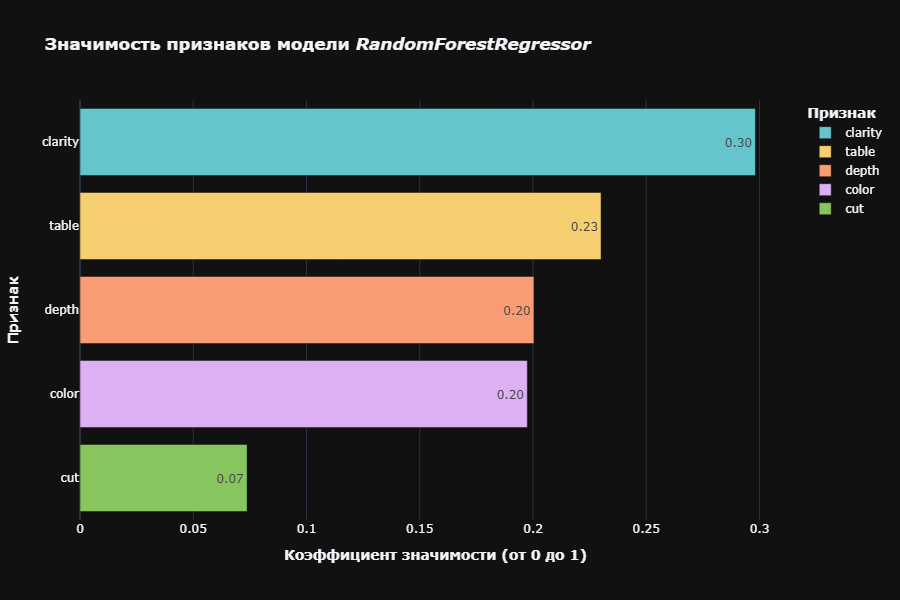

In [38]:
display_feature_importances(rf_pipeline)

Итак, случайный лес не помог улучшить метрику $MAPE$, всё осталось также, как и в одном решающем дереве.

Попробуем улучшить метрику с помощью **бустинга**. Будем использовать более современный фреймворк - *XGBoost*
***

<a id="ml_xgb"></a>

### *XGBRegressor*
<img src=../img/gradient_boosting.png></img>

  0%|          | 0/50 [00:00<?, ?it/s]

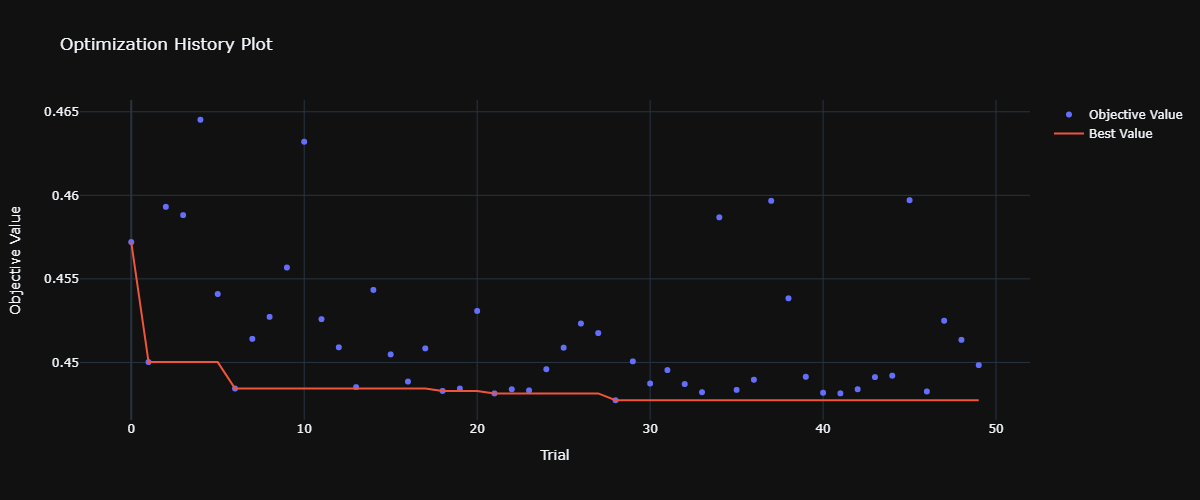

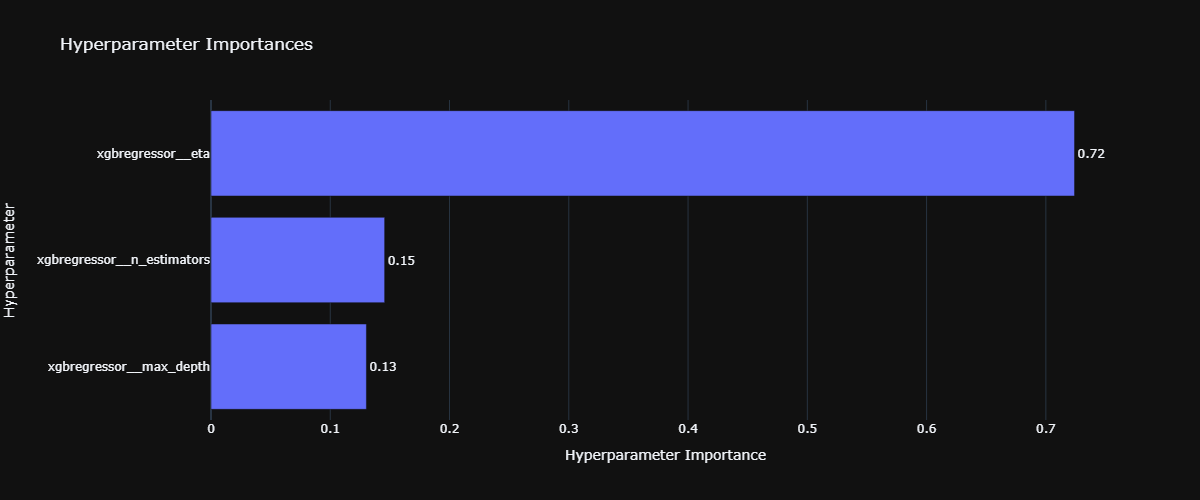

##### Оптимизация заняла $3$ минут(-ы) $12$ секунд(-ы)<p>         Наилучшее значение метрики $MAPE$ на кросс-валидации: $0.448$

##### Подобранные гиперпараметры для *XGBRegressor*:

{'xgbregressor__booster': 'gbtree',
 'xgbregressor__device': 'cuda',
 'xgbregressor__verbosity': 0,
 'xgbregressor__tree_method': 'hist',
 'xgbregressor__eta': 0.08747188801962322,
 'xgbregressor__max_depth': 10,
 'xgbregressor__n_estimators': 126}

In [39]:
# Константные параметры
xgb_default_params = dict(
    # тип бустера
    booster='gbtree',
    # аппаратное ускорение на GPU
    device='cuda',
    # отключение служебных сообщений от модели
    verbosity=0,
    # градиентный бустинг на основе гистограмм, как правило, намного быстрее
    tree_method='hist'
)
# Параметры для оптимизации
xgb_optimize_params = dict(
    # темп обучения
    eta=np.array([0.01, 1], dtype=float),
    # максимальная глубина
    max_depth=np.array([2, 10], dtype=int),
    # количество моделей в ансамбле
    n_estimators=np.array([20, 150], int)
)
# Создаем пайплайн градиетного бустинга
xgb_pipeline = make_pipeline(
    column_pipeline,
    xgb.XGBRegressor()
)
# Подбираем гиперпараметры на 50 итерациях
best_xgb_params = get_best_hyperparameters(
    pipeline=xgb_pipeline,
    n_trials=50,
    optimize_params=xgb_optimize_params,
    default_params=xgb_default_params
)

In [40]:
xgb_pipeline = xgb_pipeline.set_params(**best_xgb_params)
print_metrics(xgb_pipeline)

Значение метрики $MAPE$ при использовании *XGBRegressor*:<br>             <ul><li>train: $0.386$</li><li>test: $0.449$</li></ul>

Метрика стала хуже, чем у случайного леса. Вероятно, для данной задачи бустинг либо не подходит, либо искать минимум придётся намного дольше

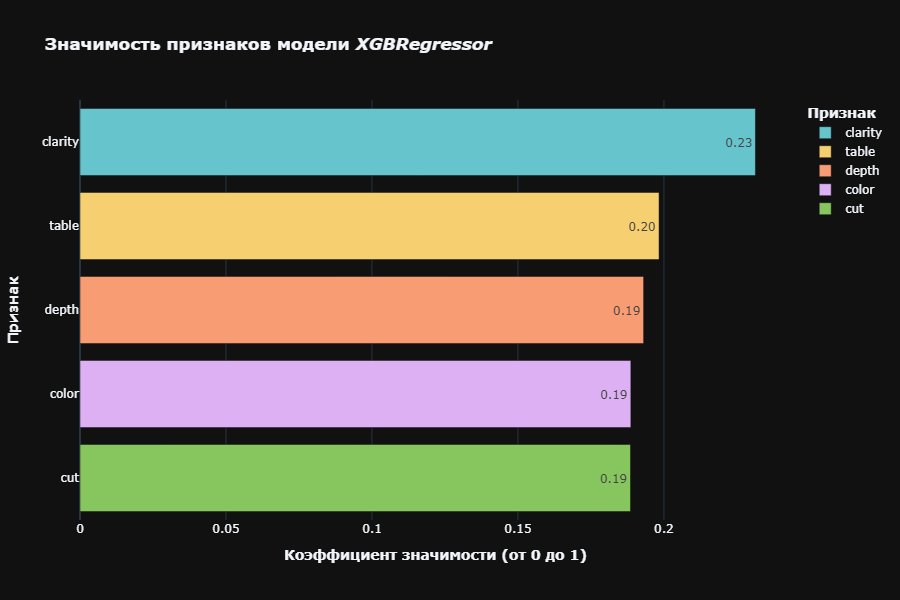

In [41]:
display_feature_importances(xgb_pipeline)

Сделаем небольшое сравнение и перейдем к другому методу построения моделей - с учетом `carat`
***

<a id="ml_partial_conclusion"></a>

### Промежуточный вывод

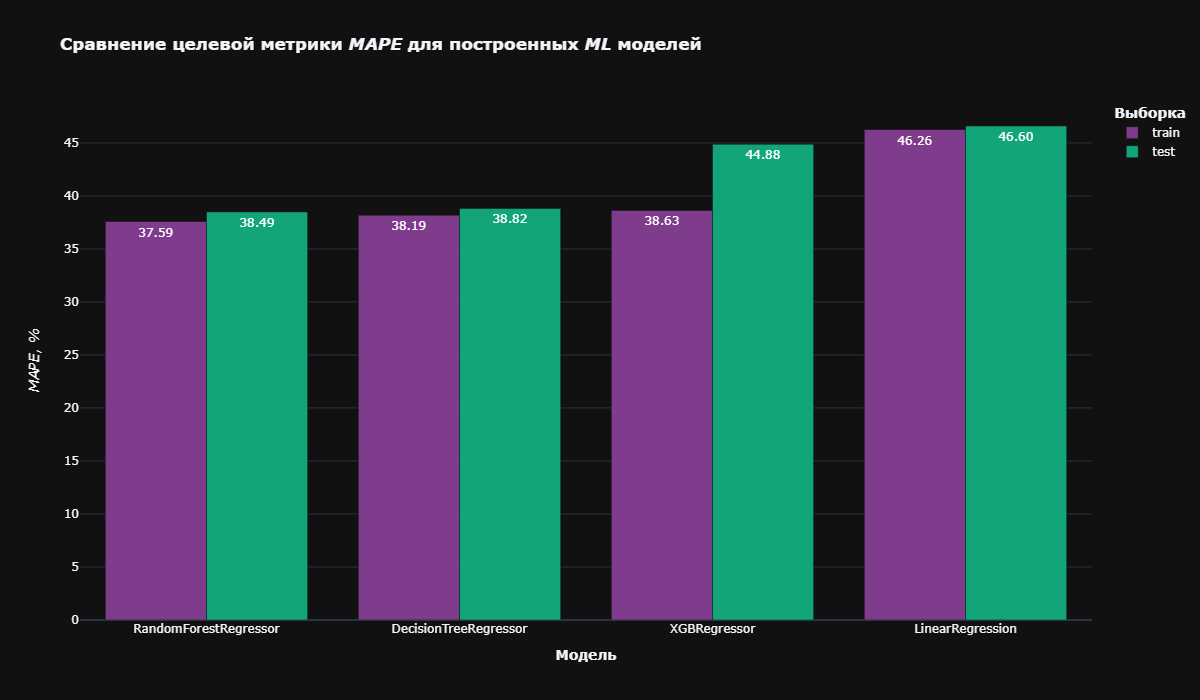

In [42]:
def display_model_comparison(metrics:dict):
    df = pd.DataFrame(metrics).drop_duplicates(subset=['model', 'sample'], keep='last').sort_values(by='metric', ascending=True)
    df['metric'] = df['metric'] * 100
    px.bar(
        data_frame=df,
        y='metric',
        x='model',
        color='sample',
        width=1200,
        height=700,
        text_auto='.2f',
        color_discrete_sequence=px.colors.qualitative.Bold,
        barmode='group',
        labels={'model': '<b>Модель</b>', 'metric': '<i>MAPE, %</i>', 'sample': '<b>Выборка</b>'},
        title='<b>Сравнение целевой метрики <i>MAPE</i> для построенных <i>ML</i> моделей</b>'
    ).show()
    
display_model_comparison(metrics_dict)

***

<a id="ml_with_weight"></a>

## <center>Machine Learning (предсказание целевого признака с учетом веса)</center>

<a id="ml_change_1"></a>

### Разделение выборки на обучающую и тестовую

In [41]:
X, y = data.drop(columns=['price', 'price_per_carat']), data['price']
# Могли появиться дубликаты в выборке X, удалим их
X.drop_duplicates(inplace=True)
y = y[X.index]
# Разделяем выборки на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
# Отображаем информацию
print(
    f'Размер обучающей выборки: {X_train.shape}\n',
    f'Размер тестовой выборки: {X_test.shape}',
    end='', 
    sep=''
)
display(Markdown('Пример выборки `X_train`'))
display(X_train.sample(3, random_state=RANDOM_STATE))

Размер обучающей выборки: (37503, 9)
Размер тестовой выборки: (16073, 9)

Пример выборки `X_train`

,carat,cut,color,clarity,depth,table,x,y,z
11232,1.03,Very Good,H,SI2,62.8,59.0,6.41,6.46,4.04
39933,0.30,Premium,H,VS1,62.1,59.0,4.25,4.28,2.65
19782,1.21,Ideal,E,VS1,62.2,57.0,6.83,6.80,4.24


***

<a id="ml_change_2"></a>

### Изменение пайплайна предобработки данных
Почти тот же самый пайплайн, что в предыдущем разделе, только вернем признак `carat`

In [42]:
column_pipeline = make_column_transformer(
    ('drop', ['x', 'y', 'z']),
    (ord_encoder, ['color', 'clarity', 'cut']),
    (RobustScaler(), ['depth', 'table', 'carat'])
)
column_pipeline

ColumnTransformer(transformers=[('drop', 'drop', ['x', 'y', 'z']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['J', 'I', 'H', 'G',
                                                             'F', 'E', 'D'],
                                                            ['I1', 'SI2', 'SI1',
                                                             'VS2', 'VS1',
                                                             'VVS2', 'VVS1',
                                                             'IF'],
                                                            ['Fair', 'Good',
                                                             'Very Good',
                                                             'Premium',
                                                             'Ideal']]),
                                 ['color', 'clarity', 'cut']),
                                ('robustscaler', RobustScaler(),
                                 ['depth', 'table', 'carat'])])

Так как теперь в данных учитывается вес, который очень сильно коррелирует с целевым (цена), то использовать модель, основанную на деревьях - плохая идея. Дело в том, что практически в каждой вершине деревьев будет предикат, основанный именно на весе.  
Это приведет к следующей **проблеме** на скриншоте ниже - **небольшое изменение веса никак не влияет на целевой признак** (использовалась модель *XGBRegressor*):

<img src=../img/comparison.png></img>

Будем использовать **линейные модели** и простую **нейронную сеть**
***

<a id="ml_lr_2"></a>

### *LinearRegression*
<img src=../img/linear_regression.png></img>

In [45]:
# Обнулим словарь с метриками предыдущих моделей, чтобы записывать в него новые значения
metrics_dict = {
    'model': [],
    'metric': [],
    'sample': []
}
# Создаем пайплайн линейной регрессии
lr_pipeline = make_pipeline(
    column_pipeline,
    LinearRegression()
)
# Выводим результат
print_metrics(lr_pipeline)

Значение метрики $MAPE$ при использовании *LinearRegression*:<br>             <ul><li>train: $0.491$</li><li>test: $0.479$</li></ul>

Добавим полиномиальную зависимость 3-й степени, чтобы уменьшить смещение
***

<a id="ml_lr_pf_2"></a>

### *LinearRegression & PolynomialFeatures*
<img src=../img/polynomial_regression.png></img>

In [46]:
# Создаем пайплайн линейной регрессии на полиномиальных признаках 3-ей степени
poly_lr_pipeline = make_pipeline(
    column_pipeline,
    PolynomialFeatures(degree=3, include_bias=False),
    LinearRegression()
)
print_metrics(poly_lr_pipeline)

Значение метрики $MAPE$ при использовании *LinearRegression*:<br>             <ul><li>train: $0.140$</li><li>test: $0.137$</li></ul>

Теперь метрика уже значительно лучше. Попробуем использовать полиномиальные признаки в связке со **стохастическим градиентным спуском**. Сразу же начнем с поиска гиперпараметров
***

<a id="ml_sgd"></a>

### *SGDRegressor*
<img src=../img/gradient_descent.png></img>

  0%|          | 0/100 [00:00<?, ?it/s]

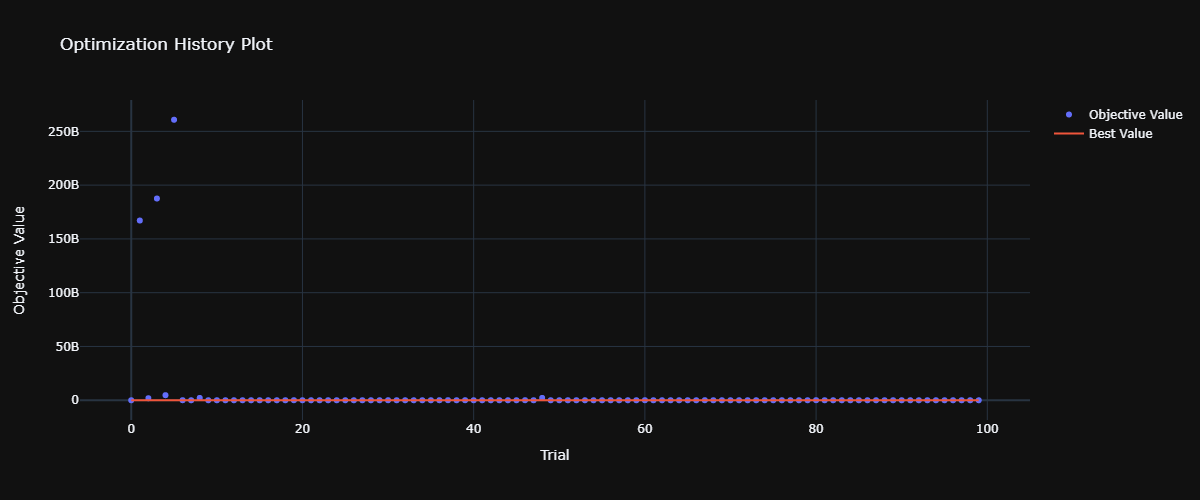

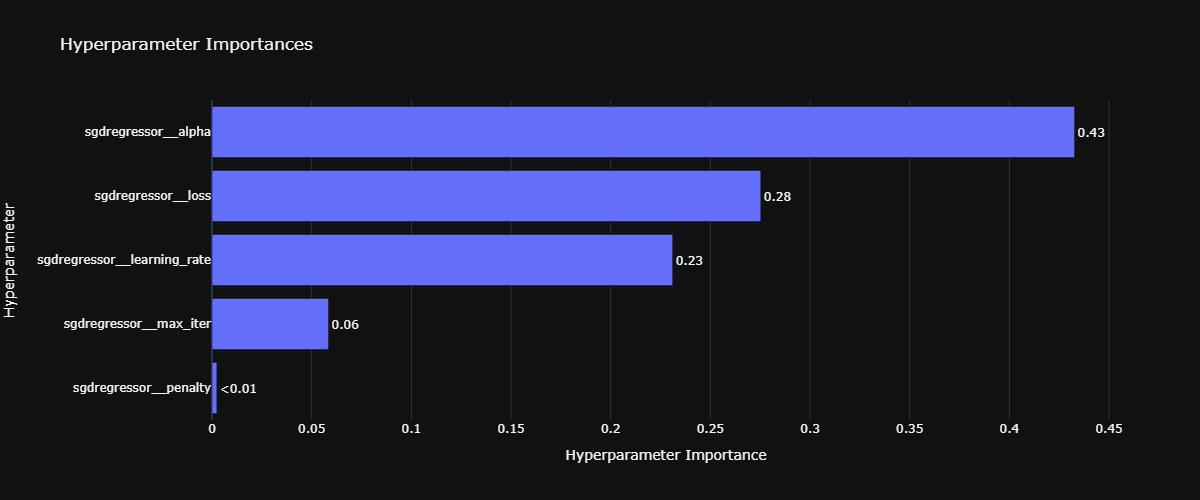

##### Оптимизация заняла $5$ минут(-ы) $19$ секунд(-ы)<p>         Наилучшее значение метрики $MAPE$ на кросс-валидации: $0.116$

##### Подобранные гиперпараметры для *SGDRegressor*:

{'sgdregressor__random_state': 42,
 'sgdregressor__loss': 'epsilon_insensitive',
 'sgdregressor__alpha': 0.04191534459345789,
 'sgdregressor__max_iter': 90414,
 'sgdregressor__learning_rate': 'adaptive',
 'sgdregressor__penalty': 'l1'}

In [47]:
# Параметры для поиска с помощью optuna
sgd_optimize_params = dict(
    # функция потерь
    loss=np.array(['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], dtype=object),
    # параметр, влияющий на "силу" регуляризации
    alpha=np.array([1e-4, 1e-1], dtype=float),
    # максимальное количество итераций градиетного спуска
    max_iter=np.array([1000, 100_000], dtype=int),
    # тип темпа обучения
    learning_rate=np.array(['invscaling', 'constant', 'adaptive'], dtype=object),
    # регуляризация
    penalty=np.array(['l2', 'l1'], dtype=object)
)
# Константный параметр (случайная инициализация)
sgd_default_params = dict(
    random_state=RANDOM_STATE
)
# Создаём пайплайн стохастического градиетного спуска на полиномиальных признаках
sgd_pipeline = make_pipeline(
    column_pipeline,
    PolynomialFeatures(degree=3, include_bias=False),
    SGDRegressor()
)
# Запускаем оптимизацию и получаем словарь из подобрынных параметров
best_sgd_params = get_best_hyperparameters(
    pipeline=sgd_pipeline,
    n_trials=100,
    optimize_params=sgd_optimize_params,
    default_params=sgd_default_params
)

In [48]:
# Зададим подобранные параметры и выведем метрики
sgd_pipeline = sgd_pipeline.set_params(**best_sgd_params)
print_metrics(sgd_pipeline)

Значение метрики $MAPE$ при использовании *SGDRegressor*:<br>             <ul><li>train: $0.115$</li><li>test: $0.113$</li></ul>

Градиентный спуск действительно помог улучшить метрику ($MAPE$ на $4\%$ меньше, чем у обычной линейной регрессии). Последним шагом в попытке добиться наилучшего качества будет нейронная сеть
***

<a id="ml_nn"></a>

### *MLPRegressor*
<img src=../img/neural_network.png></img>

Будем использовать одну из простейших архитектур нейронных сетей - перцептрон. Возможно, в данных есть какие-то нелинейные зависимости, поэтому добавим 4 скрытых слоя, уменьшая количество нейронов на каждом следующем слое.

In [43]:
nn_pipeline = make_pipeline(
    column_pipeline,
    MLPRegressor(
        # 4 скрытых слоя
        hidden_layer_sizes=[512, 256, 128, 64],
        # функция активация нейрона
        activation='relu',
        # метод оптимизации
        solver='adam',
        # случайная инициализация
        random_state=RANDOM_STATE,
        # максимальное количество эпох, если параметр early_stopping не прекратил обучение раньше
        max_iter=300,
        # возможность прекратить обучение, если функция потерь перестала уменьшаться с новыми эпохами
        early_stopping=True
    )
)
print_metrics(nn_pipeline)

Значение метрики $MAPE$ при использовании *MLPRegressor*:<br>             <ul><li>train: $0.085$</li><li>test: $0.086$</li></ul>

Посмотрим на историю обучения нейронной сети (как менялась метрика в зависимости от эпохи)

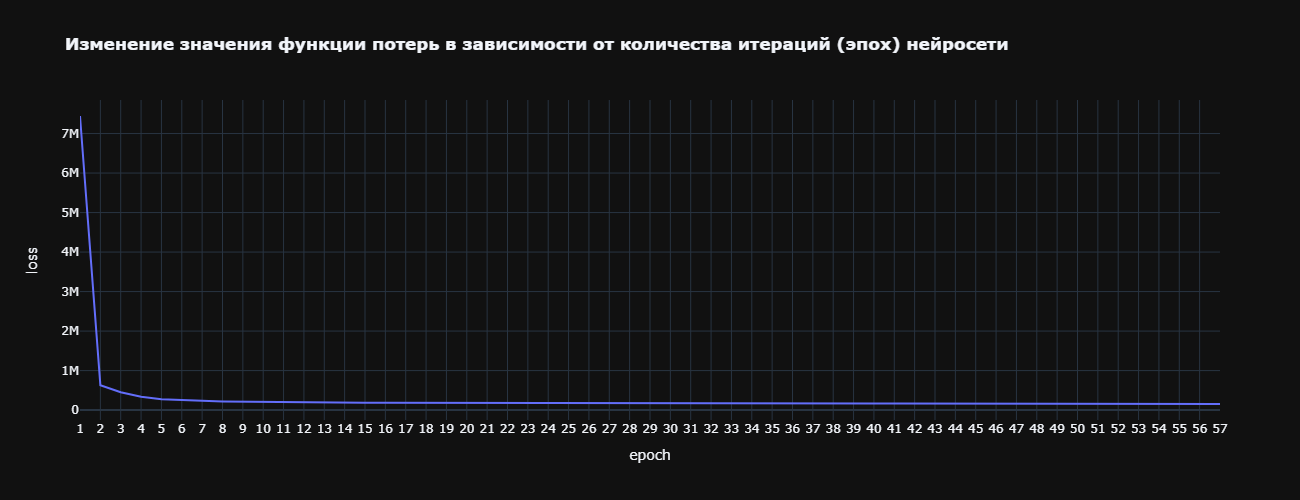

In [44]:
# Создадим датафрейм для визуализации функции потерь и визуализируем его
loss_curve_df = pd.DataFrame({
    'epoch': range(1, nn_pipeline[-1].n_iter_+1),
    'loss': nn_pipeline[-1].loss_curve_
})
px.line(
    data_frame=loss_curve_df,
    x='epoch',
    y='loss',
    title='<b>Изменение значения функции потерь в зависимости от количества итераций (эпох) нейросети</b>',
    width=1300,
    height=500
).update_xaxes(tickmode='linear', tick0=1, dtick=1)

Видно, что модель довольно быстро смогла сойтись к минимуму, всего за 57 эпох

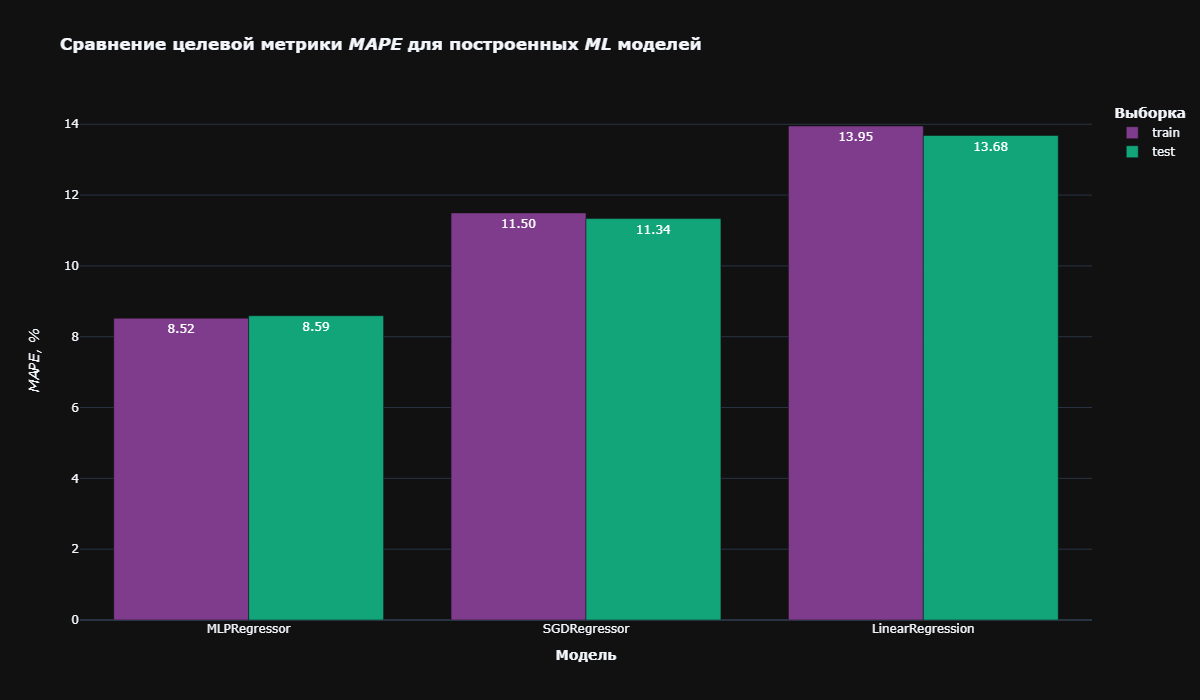

In [51]:
display_model_comparison(metrics_dict)

Нейронная сеть показала самый лучший результат. Сохраним её в файл для дальнейшего деплоя модели

In [ ]:
with open('../app/models/nn_regressor.pkl', 'wb') as nn_file:
    pickle.dump(nn_pipeline, nn_file)

Проверим, что модель корректно десериализируется

In [ ]:
with open('../app/models/nn_regressor.pkl', 'rb') as nn_file:
    nn_loaded = pickle.load(nn_file)
nn_loaded

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop',
                                                  ['x', 'y', 'z']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF'],
                                                                             ['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal']]),
                                                  ['color', 'clarity', 'cut']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['depth', 'table',
                                                   'carat'])])),
                ('mlpregressor',
                 MLPRegressor(early_stopping=True,
                              hidden_layer_sizes=[512, 256, 128, 64],
                              max_iter=300, random_state=42))])

***

<a id="conclusion"></a>

## <center>Вывод по проделанной работе</center>
### Интерпретация целевой метрики
Т.к. мы использовали $MAPE$, которое показывает долю ошибок, то хотелось бы знать, на сколько именно модель ошибается в валюте. Выведем $MAE$

In [ ]:
mae = mean_absolute_error(y_test, nn_pipeline.predict(X_test)).round(2)
display(Markdown(f'##### Модель (нейронная сеть) ошибается в среднем на ${mae} \space \$$  в предсказании цены алмазов'))

##### Модель (нейронная сеть) ошибается в среднем на $298.08 \space \$$  в предсказании цены алмазов

Учитывая, что алмазы стоят довольно дорого (от нескольких тысяч долларов), то можно сделать вывод, что модель отлично справляется с поставленной задачей

### Сравнение качества моделей
1. Вариант предсказания цены за 1 карат оказался не очень подходящим для данного датасета - признаки (без учета веса) недостаточно хорошо описывают целевую переменную, поэтому лучший результат, которого получилось добиться - $MAPE \approx 38 \%$

2. Вариант предсказания цены с учетом веса показал удовлетворительный результат. 
    * Сначала обычная линейная регрессия не справилась ($MAPE \approx 48\%$), а вот добавление полиномиальной зависимости резко улучшило результат ($MAPE \approx 13.7 \%$). 

    * Следующим шагом стала удачная попытка использования стохастического градиентного спуска в связке с полиномиальными признаками - получилось снизить метрику ещё на $2.5\%$ ($MAPE \approx 11.3\%$). 

    * Последней моделью, что я использовал, была нейронная сеть (перцептрон). После нескольких экспериментов с количеством слоёв и количеством нейронов получилось добиться очень хорошей метрики - $MAPE \approx 8.6 \%$